# Predicting Student Achievement in Portuguese Secondary Schools

In [254]:
# Import required libraries
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
sys.path.append(os.path.abspath('..'))
from utils.variables import * 
import scipy.stats as stats 
from scipy.stats import pearsonr, f_oneway, ttest_ind, chi2_contingency
from IPython.display import display
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score

## 1. Load and Inspect Data

We begin by loading the dataset and examining the first few rows:

In [255]:
# Load the dataset 
df = pd.read_csv('../data/student_performance.csv')

# Display first few rows and summary statistics of numeric columns
pd.set_option('display.max_columns', None)
display(df.head())  
display(df.describe()) 

# Print columns with null values and their counts
null_counts = df.isnull().sum()
print(null_counts[null_counts > 0] if not null_counts[null_counts > 0].empty else 'Dataframe has no null values')

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,0,yes,no,no,no,yes,yes,yes,no,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,no,yes,yes,yes,yes,yes,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,no,no,yes,yes,no,no,4,3,2,1,2,5,0,11,13,13


,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
count,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000
mean,16.744222,2.514638,2.306626,1.568567,1.930663,0.221880,3.930663,3.180277,3.184900,1.502311,2.280431,3.536210,3.659476,11.399076,11.570108,11.906009
std,1.218138,1.134552,1.099931,0.748660,0.829510,0.593235,0.955717,1.051093,1.175766,0.924834,1.284380,1.446259,4.640759,2.745265,2.913639,3.230656
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,16.000000,2.000000,1.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,2.000000,0.000000,10.000000,10.000000,10.000000
50%,17.000000,2.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,2.000000,11.000000,11.000000,12.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,6.000000,13.000000,13.000000,14.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,32.000000,19.000000,19.000000,19.000000


Dataframe has no null values


**Observations:**

- There are 32 columns, including the target variable G3.

- Numeric columns show expected ranges and summary statistics.

- There are no missing values, making preprocessing simpler.

# 2. Data preprocessing
## Binary Encoding

Binary categorical features (e.g., sex, schoolsup) are mapped to 0/1 for modeling:

In [256]:
# -----------1.  Convert Binary Nominal Features to Binary Numeric -----------------

# Define binary mappings
binary_mappings = {
    'school': {'GP': 1, 'MS': 0},
    'sex': {'M': 1, 'F': 0},
    'address': {'U': 1, 'R': 0},
    'famsize': {'GT3': 1, 'LE3': 0},
    'Pstatus': {'T': 1, 'A': 0},
    'schoolsup': {'yes': 1, 'no': 0},
    'famsup': {'yes': 1, 'no': 0},
    'paid': {'yes': 1, 'no': 0},
    'activities': {'yes': 1, 'no': 0},
    'nursery': {'yes': 1, 'no': 0},
    'higher': {'yes': 1, 'no': 0},
    'internet': {'yes': 1, 'no': 0},
    'romantic': {'yes': 1, 'no': 0}
}

# Apply all mappings
df = df.replace(binary_mappings)

# Save the preprocessed dataset
df.to_csv('../data/student_preprocessed.csv', index=False)

# Display the updated dataframe
display(df.head())
display(df.info())

/var/folders/6f/2xptkgqx43s6r2pql2v71lp80000gn/T/ipykernel_896/2756750786.py:21: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_mappings)


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,1,0,18,1,1,0,4,4,at_home,teacher,course,mother,2,2,0,1,0,0,0,1,1,0,0,4,3,4,1,1,3,4,0,11,11
1,1,0,17,1,1,1,1,1,at_home,other,course,father,1,2,0,0,1,0,0,0,1,1,0,5,3,3,1,1,3,2,9,11,11
2,1,0,15,1,0,1,1,1,at_home,other,other,mother,1,2,0,1,0,0,0,1,1,1,0,4,3,2,2,3,3,6,12,13,12
3,1,0,15,1,1,1,4,2,health,services,home,mother,1,3,0,0,1,0,1,1,1,1,1,3,2,2,1,1,5,0,14,14,14
4,1,0,16,1,1,1,3,3,other,other,home,father,1,2,0,0,1,0,0,1,1,0,0,4,3,2,1,2,5,0,11,13,13


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      649 non-null    int64 
 1   sex         649 non-null    int64 
 2   age         649 non-null    int64 
 3   address     649 non-null    int64 
 4   famsize     649 non-null    int64 
 5   Pstatus     649 non-null    int64 
 6   Medu        649 non-null    int64 
 7   Fedu        649 non-null    int64 
 8   Mjob        649 non-null    object
 9   Fjob        649 non-null    object
 10  reason      649 non-null    object
 11  guardian    649 non-null    object
 12  traveltime  649 non-null    int64 
 13  studytime   649 non-null    int64 
 14  failures    649 non-null    int64 
 15  schoolsup   649 non-null    int64 
 16  famsup      649 non-null    int64 
 17  paid        649 non-null    int64 
 18  activities  649 non-null    int64 
 19  nursery     649 non-null    int64 
 20  higher    

None

**Explanation:**

- Binary variables are converted for computation in models like OLS and tree-based algorithms.

- Four multi-category nominal variables remain (dtype: object) and will be one-hot encoded later 

- Data set is clean and ready for analysis

# 3. Exploratory Data Analysis

In [257]:
# Load the saved preprocessed dataset
df = pd.read_csv('../data/student_preprocessed.csv')

## 3.1 Categorical Variables

We visualize the count of students for each category:

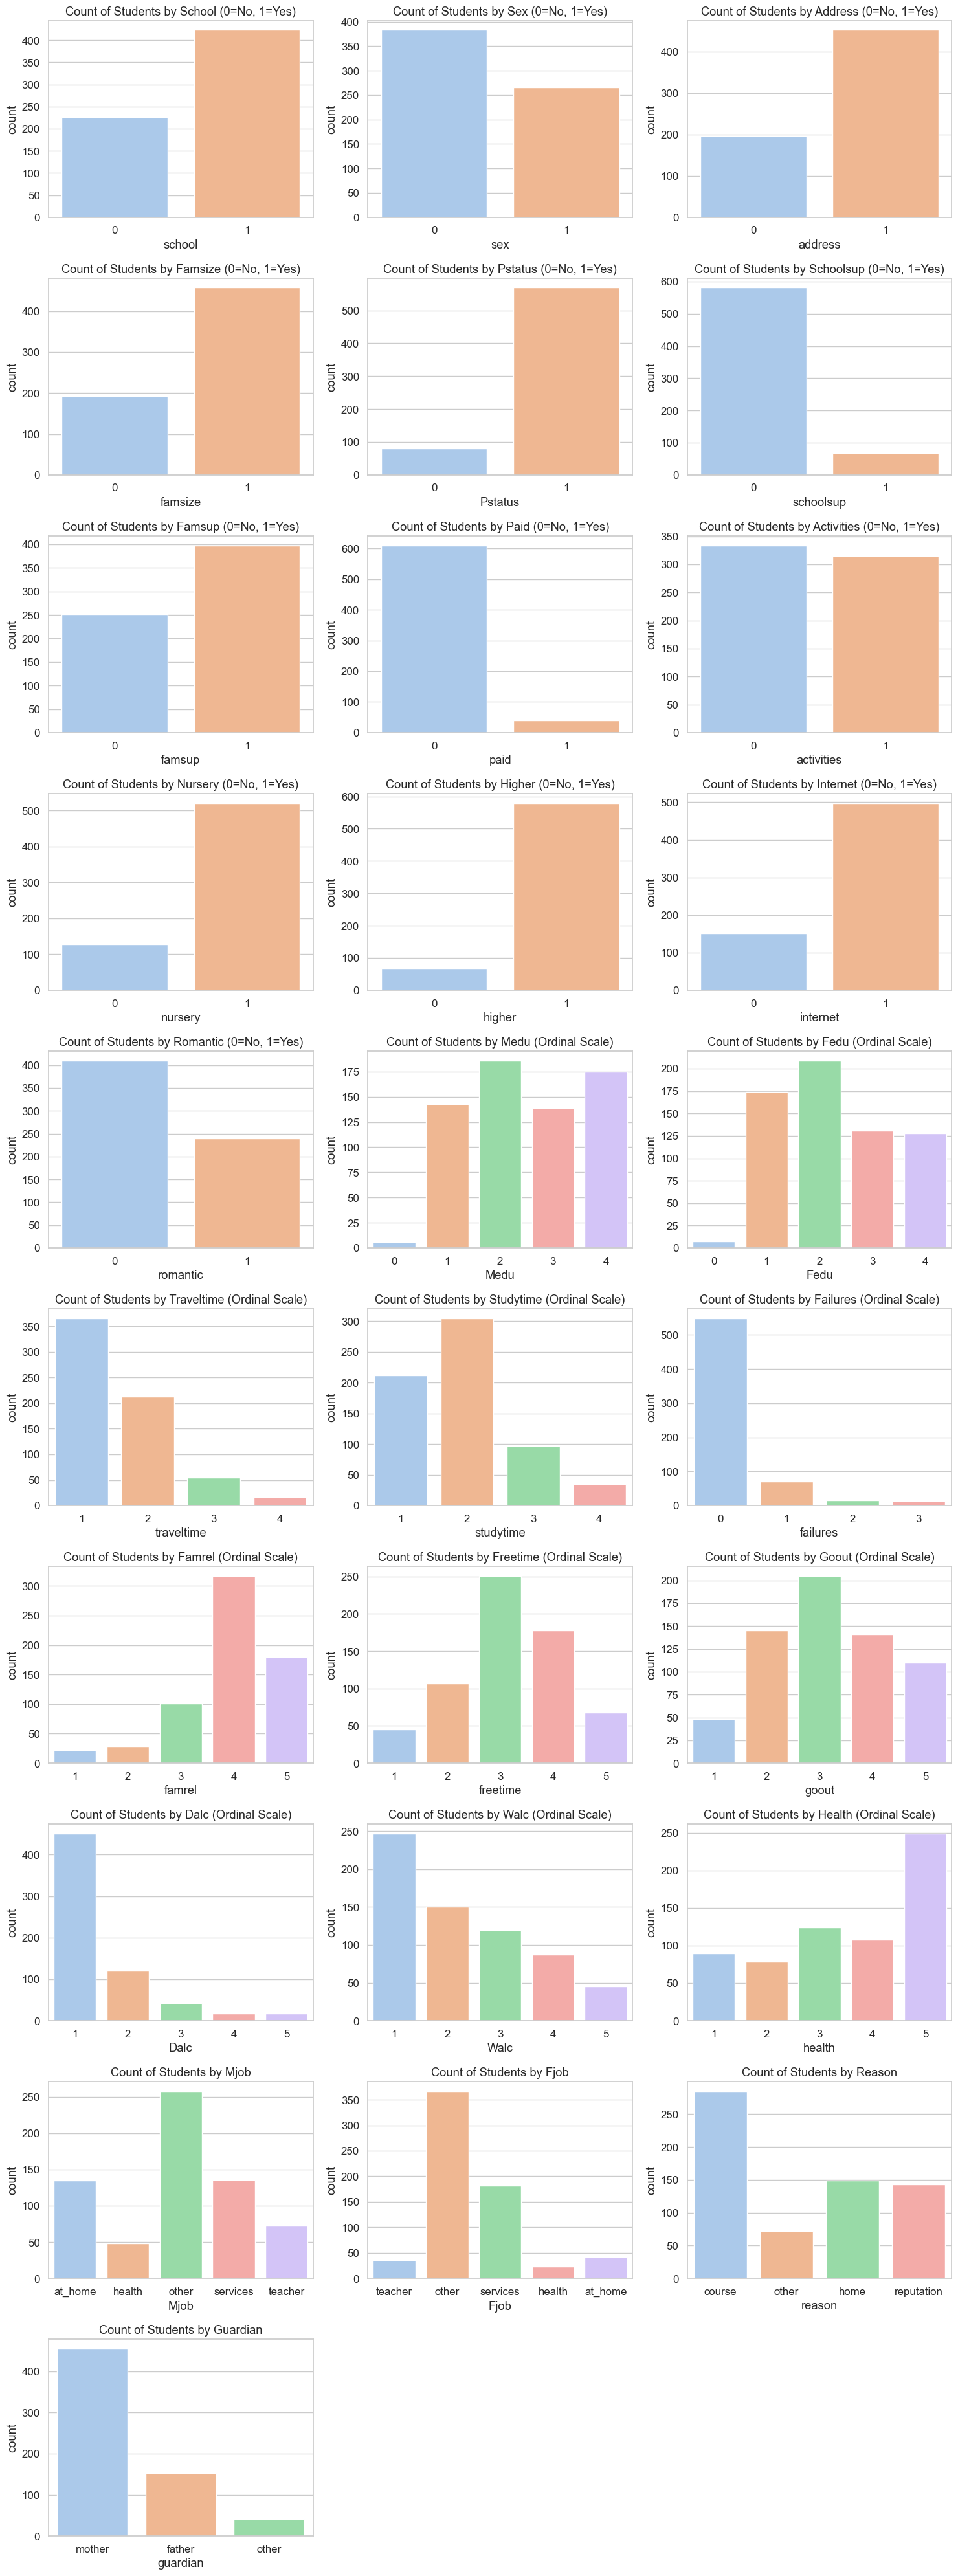

In [258]:
# ------------- Count Plots for Categorical Variables -------------------

# List of categorical columns and their titles
def make_title(var):
    if var in bin_vars:
        return f"Count of Students by {var.replace('_', ' ').title()} (0=No, 1=Yes)"
    elif var in ord_vars:
        return f"Count of Students by {var.replace('_', ' ').title()} (Ordinal Scale)"
    else:
        return f"Count of Students by {var.replace('_', ' ').title()}"
    
cat_var_tuples = [(var, make_title(var)) for var in cat_vars]

# Create grid of subplots
n_vars = len(cat_var_tuples)
n_cols = 3
n_rows = int(np.ceil(n_vars / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*4))
axes = axes.flatten()

# Plot each countplot
for i, (col, title) in enumerate(cat_var_tuples):
    sns.countplot(x=col, data=df, hue=col, palette="pastel", ax=axes[i])
    axes[i].set_title(title)
    # Only remove legend if it exists
    legend = axes[i].get_legend()
    if legend is not None:
        legend.remove()

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

**Observations:**

## 3.2 Continuous Variables

We check distributions and skewness for continuous variables:

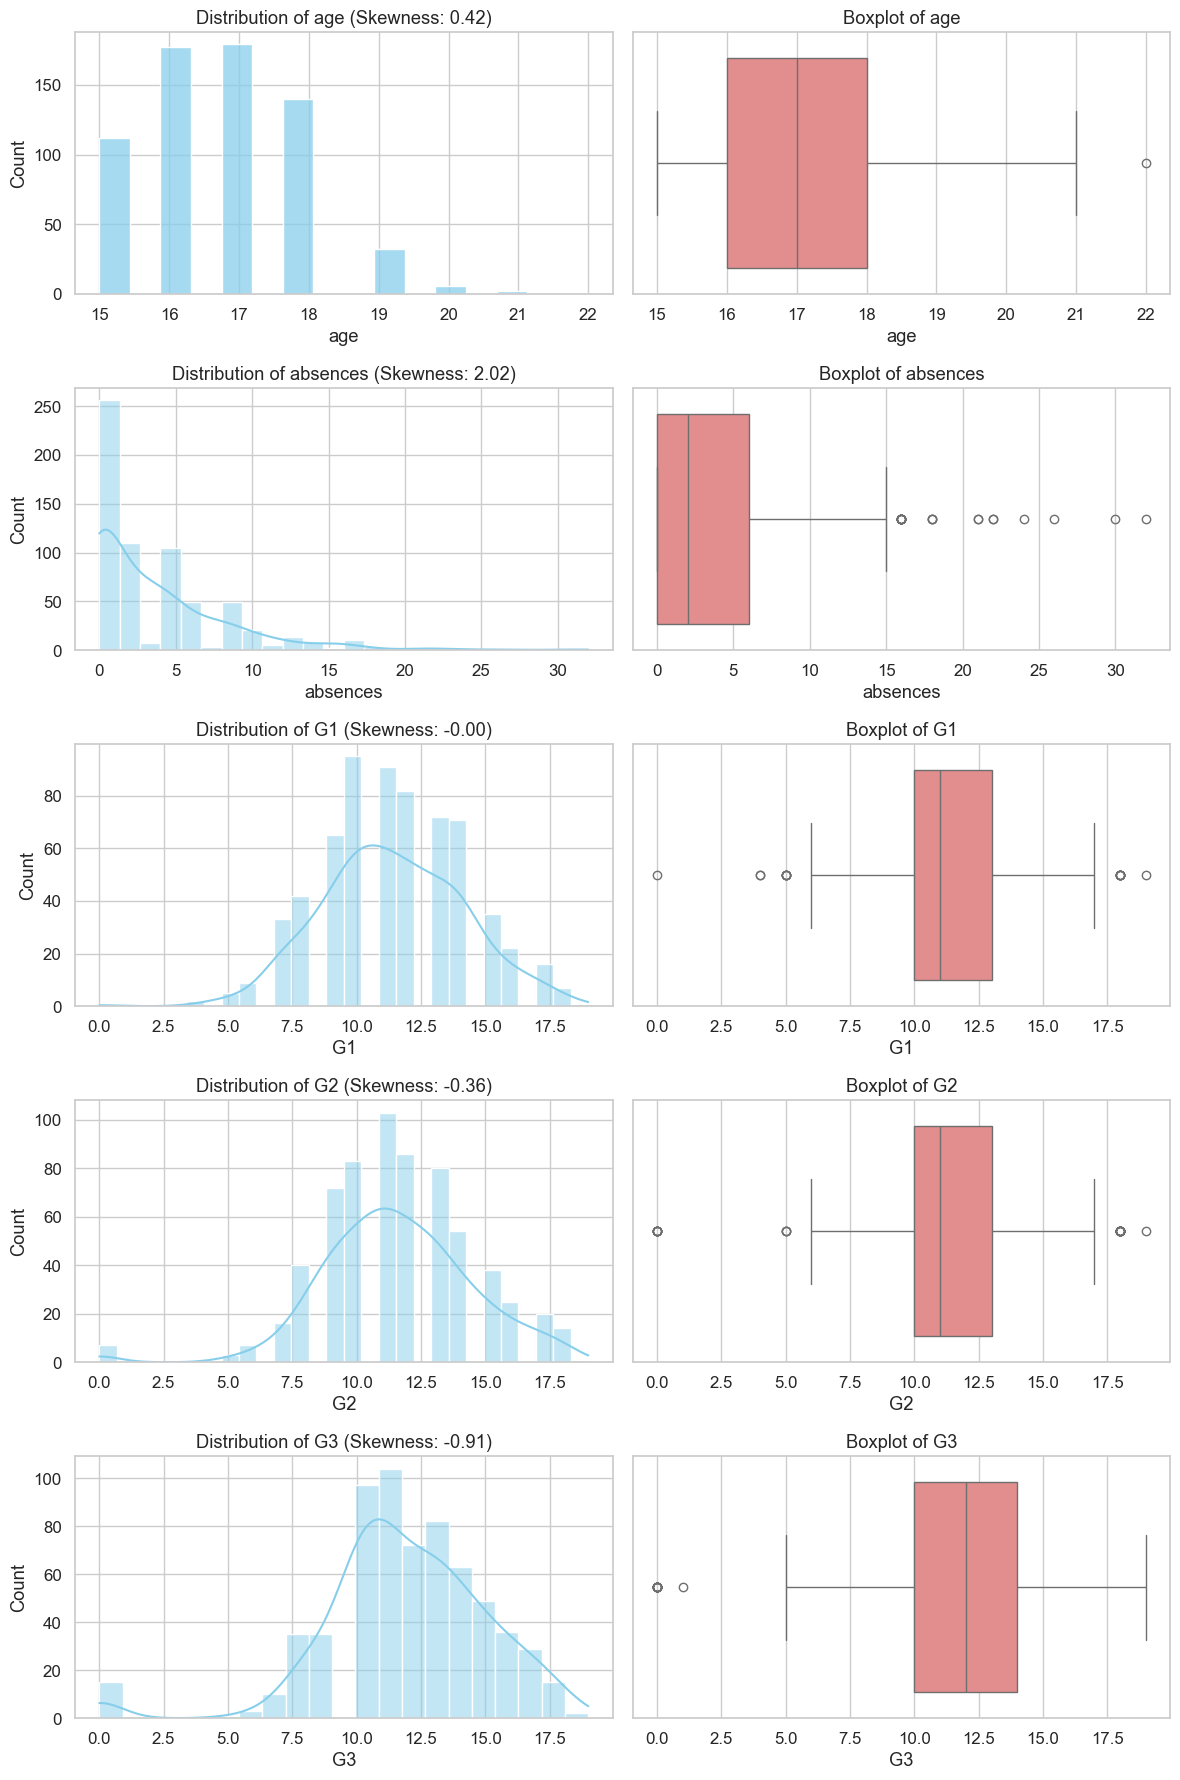

In [259]:
# --------------- Distributions & Skewness of Continuous Variables ----------------

# Set style
sns.set_theme(style="whitegrid", palette="muted", font_scale=1.1)

# Plot distributions and boxplots for continuous variables
fig, axes = plt.subplots(len(cont_vars), 2, figsize=(12, 18))
for i, var in enumerate(cont_vars):
    kde_flag = False if var == 'age' else True  # No KDE for age due to discrete nature

    # Histogram with KDE
    sns.histplot(df[var], kde=kde_flag, ax=axes[i, 0], color="skyblue")
    skewness = df[var].skew()
    axes[i, 0].set_title(f"Distribution of {var} (Skewness: {skewness:.2f})")
    
    # Boxplot
    sns.boxplot(x=df[var], ax=axes[i, 1], color="lightcoral")
    axes[i, 1].set_title(f"Boxplot of {var}")

plt.tight_layout()
plt.show()

**Observations:**

- Most variables are approximately symmetric, except absences (right-skewed).

- Boxplots reveal outliers in absences and some grades (G1, G2).

**Interpretation:**

- Skewed variables may require transformations in some models.

- Outliers can affect OLS estimates; we'll consider removing them.

## 3.3 Numeric Relationships with G3

Scatterplots with regression lines show linear associations:

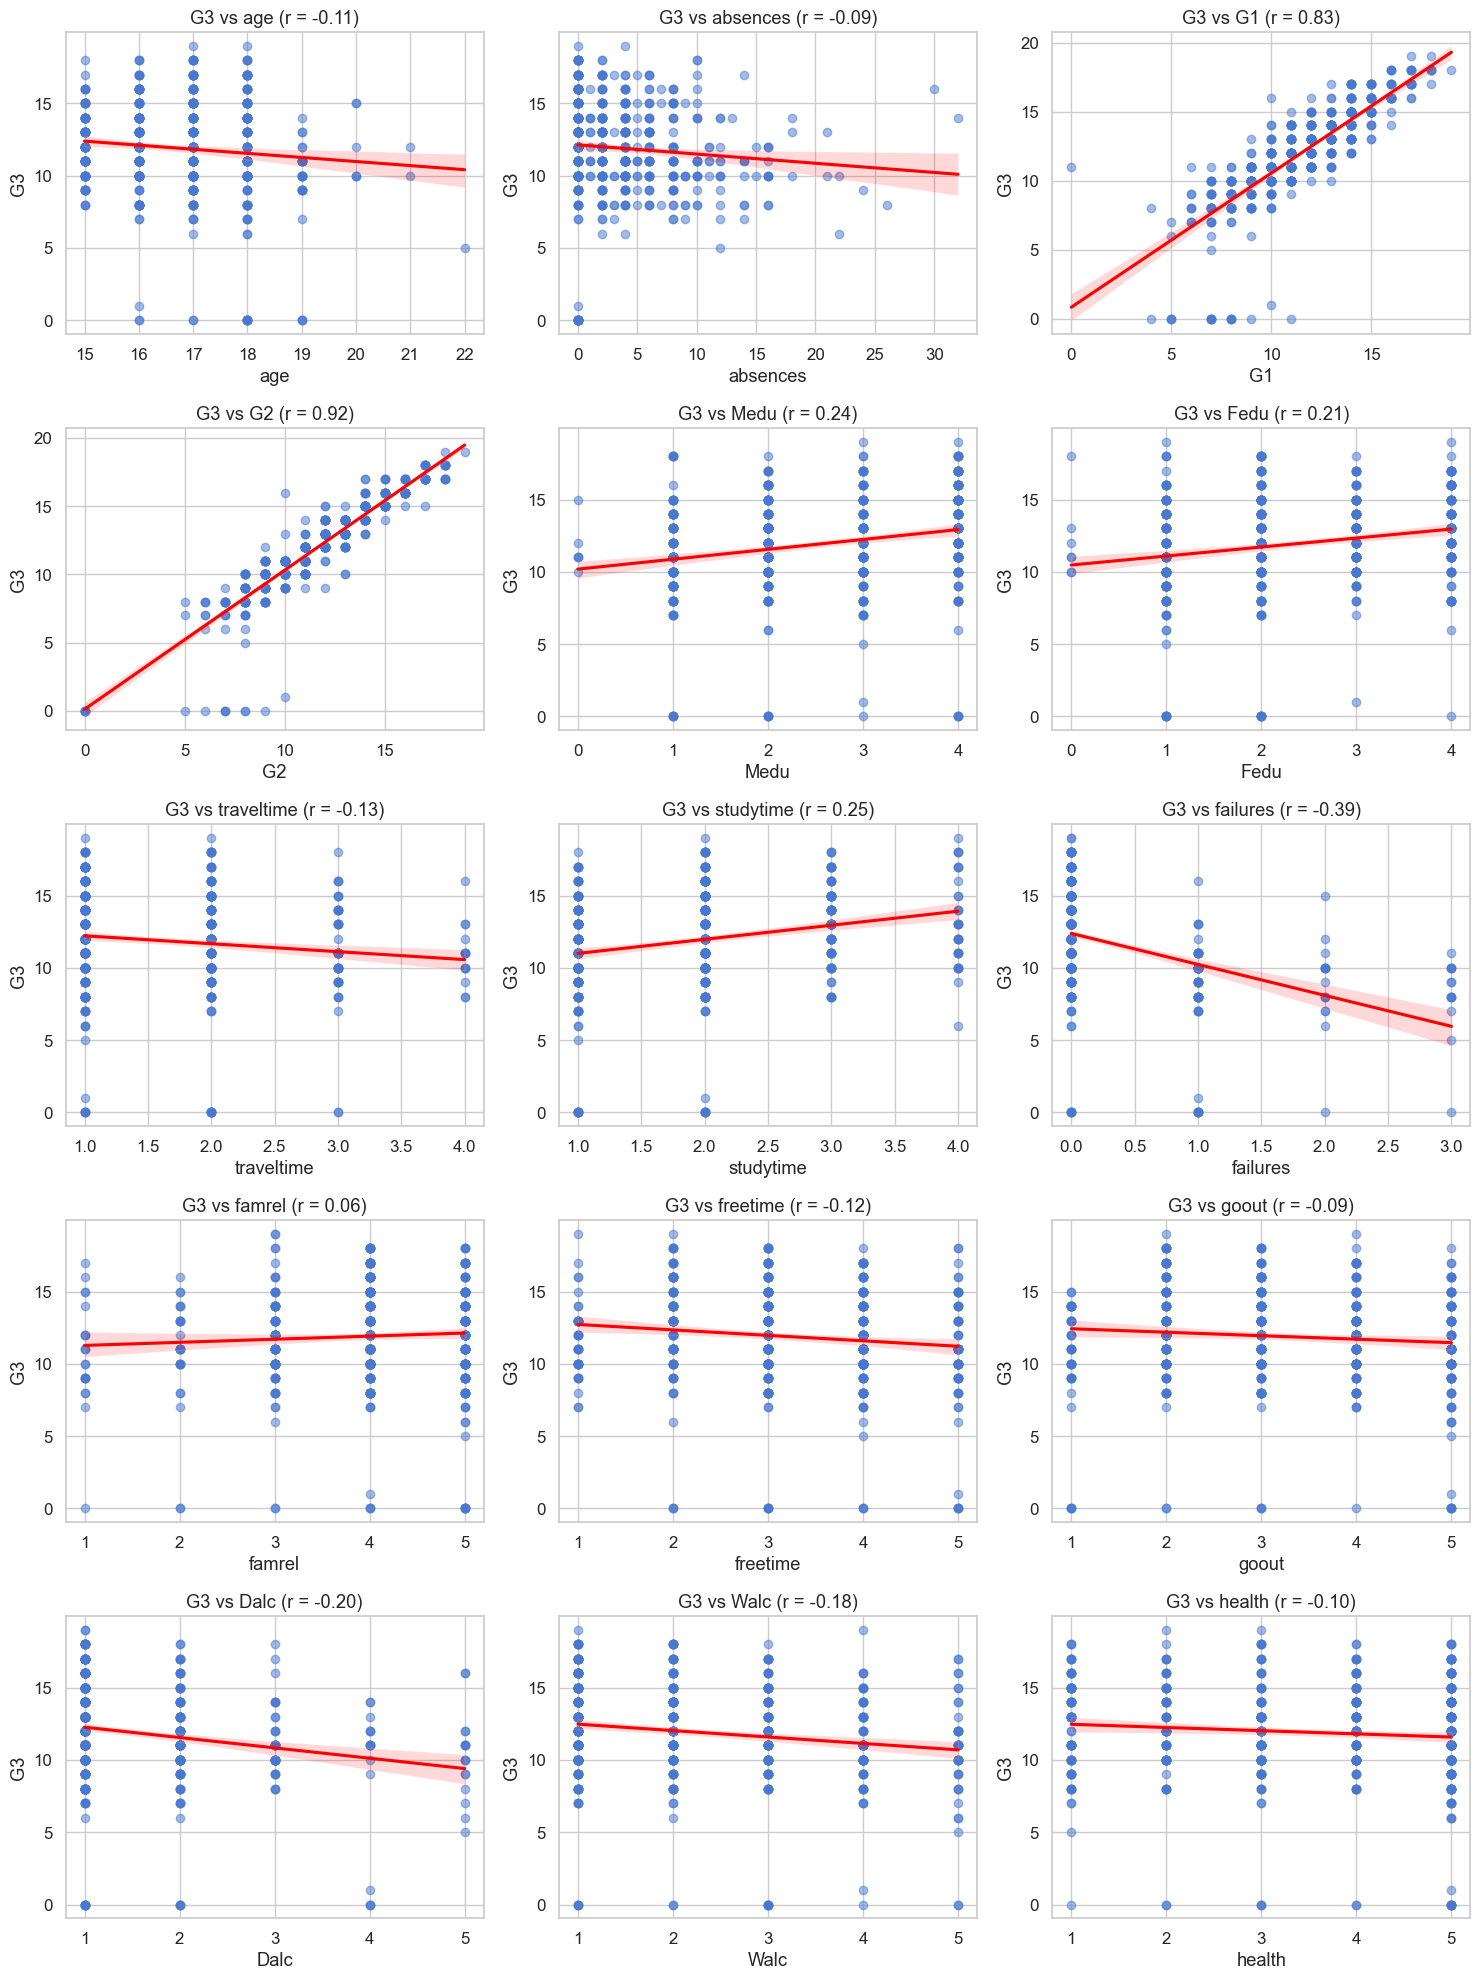

In [260]:
# -------------- Scatter Plots & Regression vs G3 for Numeric Variables ------------------

# Remove 'G3' itself to avoid plotting vs itself
numeric_vars = [var for var in numeric_vars if var != 'G3']

# Determine grid size
n_vars = len(numeric_vars)
n_cols = 3
n_rows = int(np.ceil(n_vars / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*4))
axes = axes.flatten()

# Loop through variables and plot scatter + regression vs G3
for i, col in enumerate(numeric_vars):
    # Calculate correlation coefficient
    r = df[col].corr(df['G3'])
    
    sns.regplot(
        x=col,
        y='G3',
        data=df,
        scatter_kws={'alpha':0.5},
        line_kws={'color':'red'},
        ax=axes[i]
    )
    axes[i].set_title(f"G3 vs {col} (r = {r:.2f})")

# Remove any unused axes
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

**Observations:**

- G1 and G2 show the strongest correlation with G3 (r ≈ 0.83 & 0.92).

- Other variables like famrel show weak correlations.

## 3.4 Categorical vs G3

Boxplots and barplots summarize mean performance by category:

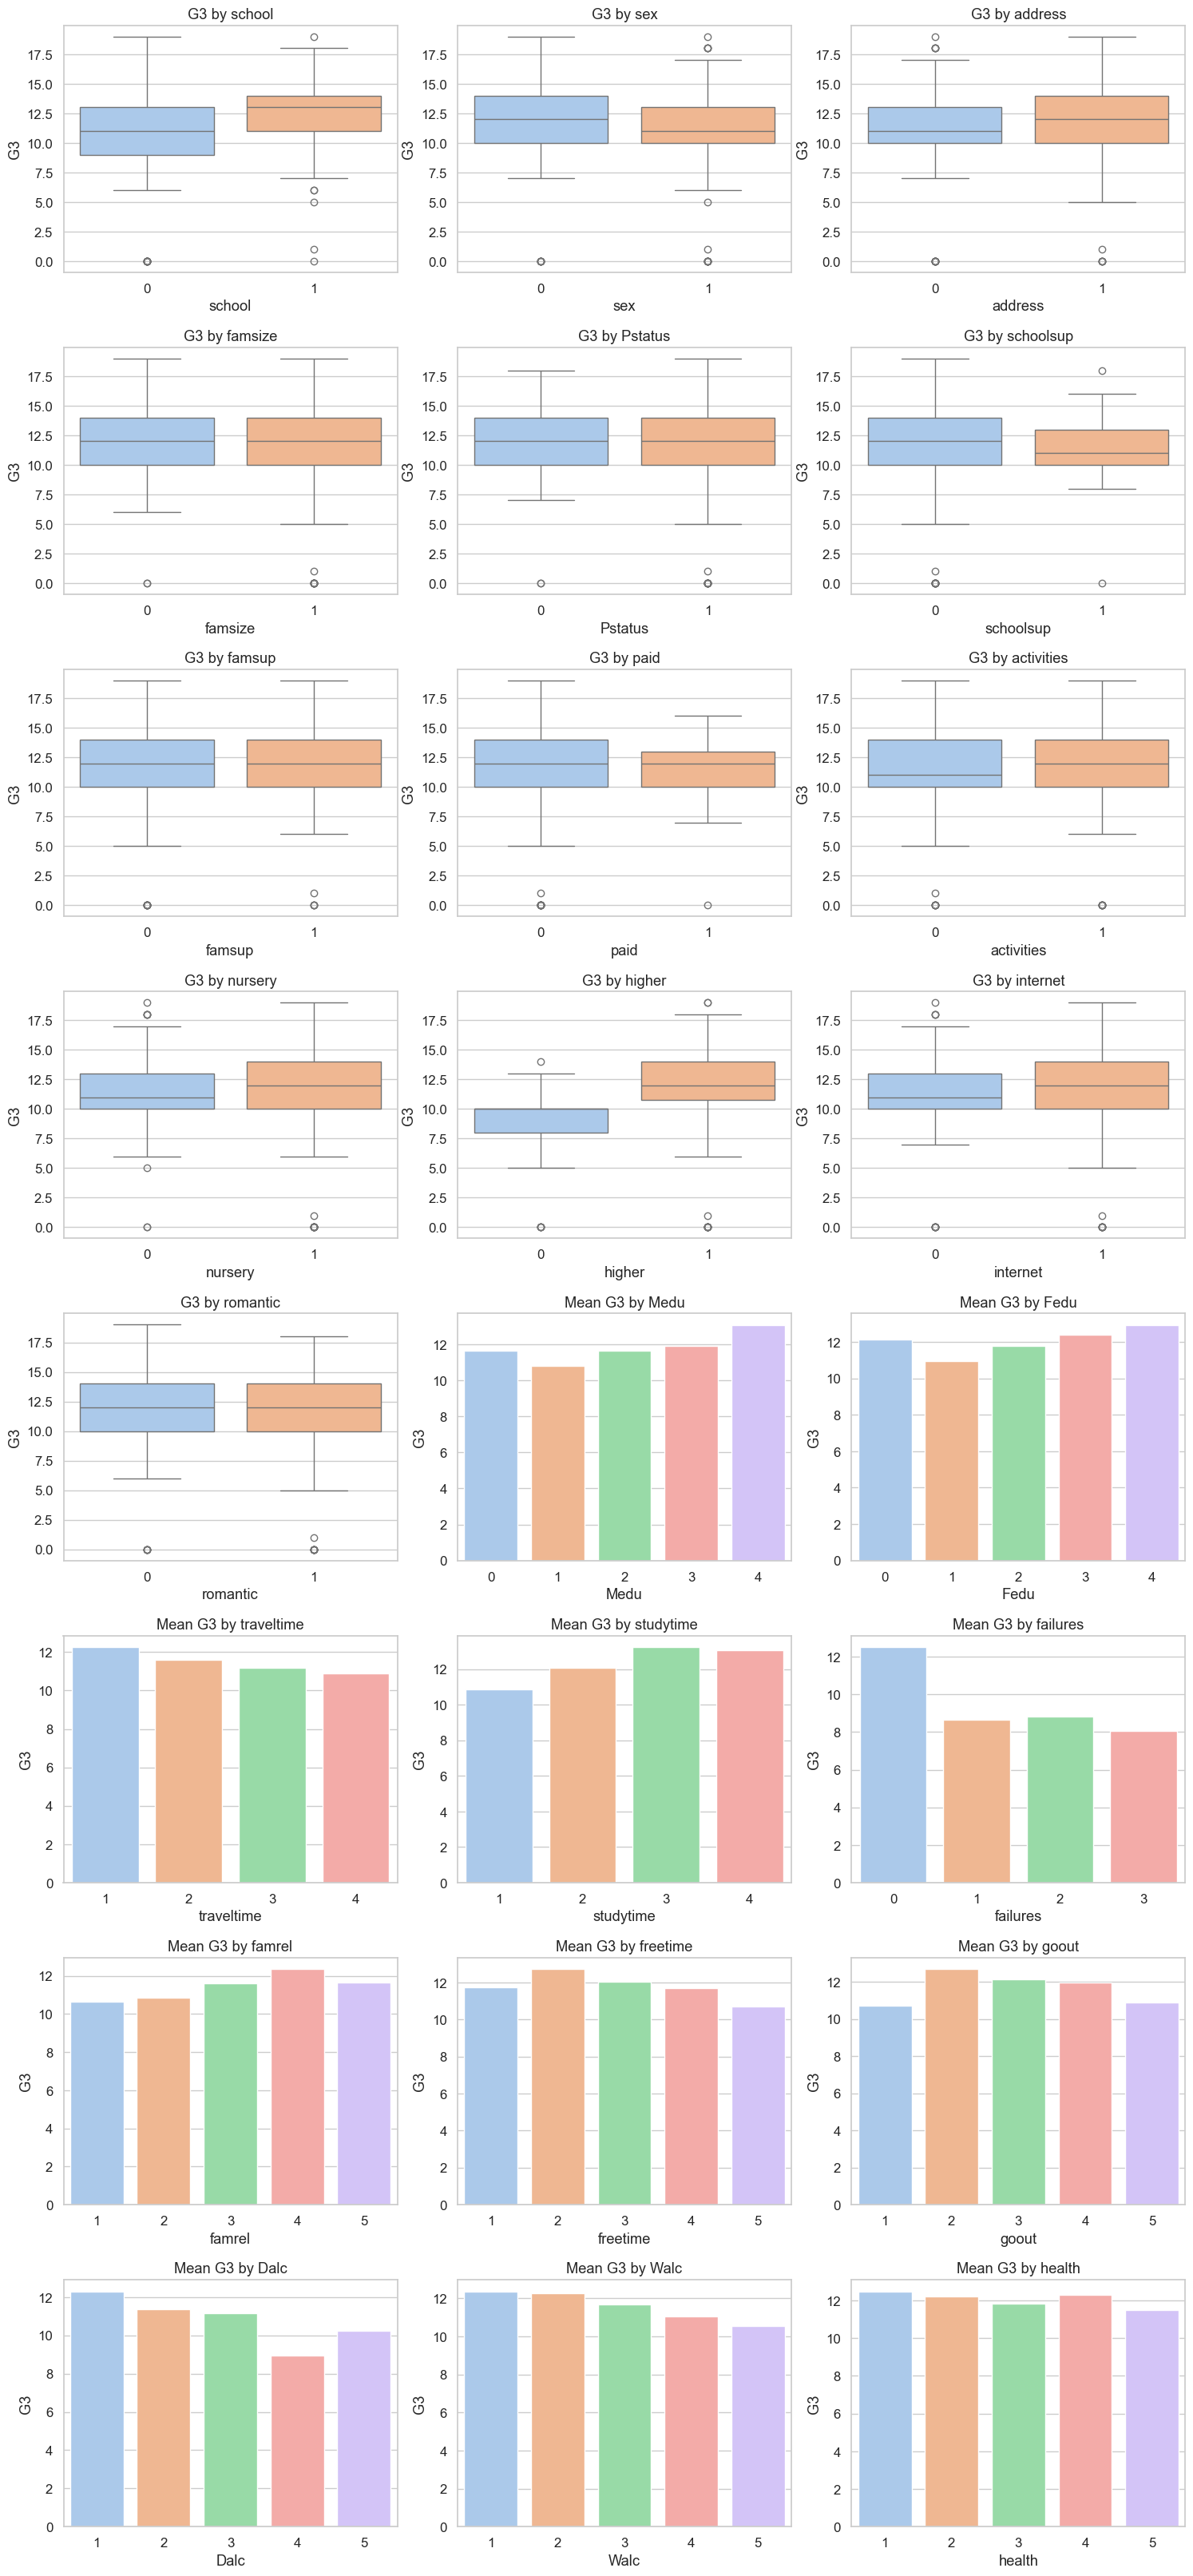

In [261]:
# -------------- Group Comparisons (Boxplots & Bar charts) ----------------

# Determine grid size
n_vars = len(cat_vars)
n_cols = 3
n_rows = int(np.ceil(n_vars / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*4))
axes = axes.flatten()

# Loop through variables
for i, var in enumerate(bin_vars + ord_vars):
    ax = axes[i]
    
    # Binary variables → boxplot
    if var in bin_vars:
        sns.boxplot(x=var, y='G3', data=df, ax=ax, palette='pastel', hue=var)
        ax.set_title(f"G3 by {var}")
        ax.get_legend().remove()
    
    # Ordinal variables → barplot of mean G3
    elif var in ord_vars:
        sns.barplot(x=var, y='G3', data=df, errorbar=None, ax=ax, palette='pastel', hue=var)
        ax.set_title(f"Mean G3 by {var}")
        ax.get_legend().remove()

# Remove unused axes
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

**Observations:**

- Students with no prior support (schoolsup=1) tend to have slightly lower G3.

- Certain ordinal variables show increasing G3 with higher levels, and some decreasing with higher levels.

## 3.5 Correlation Matrix

We examine correlations among numeric predictors:

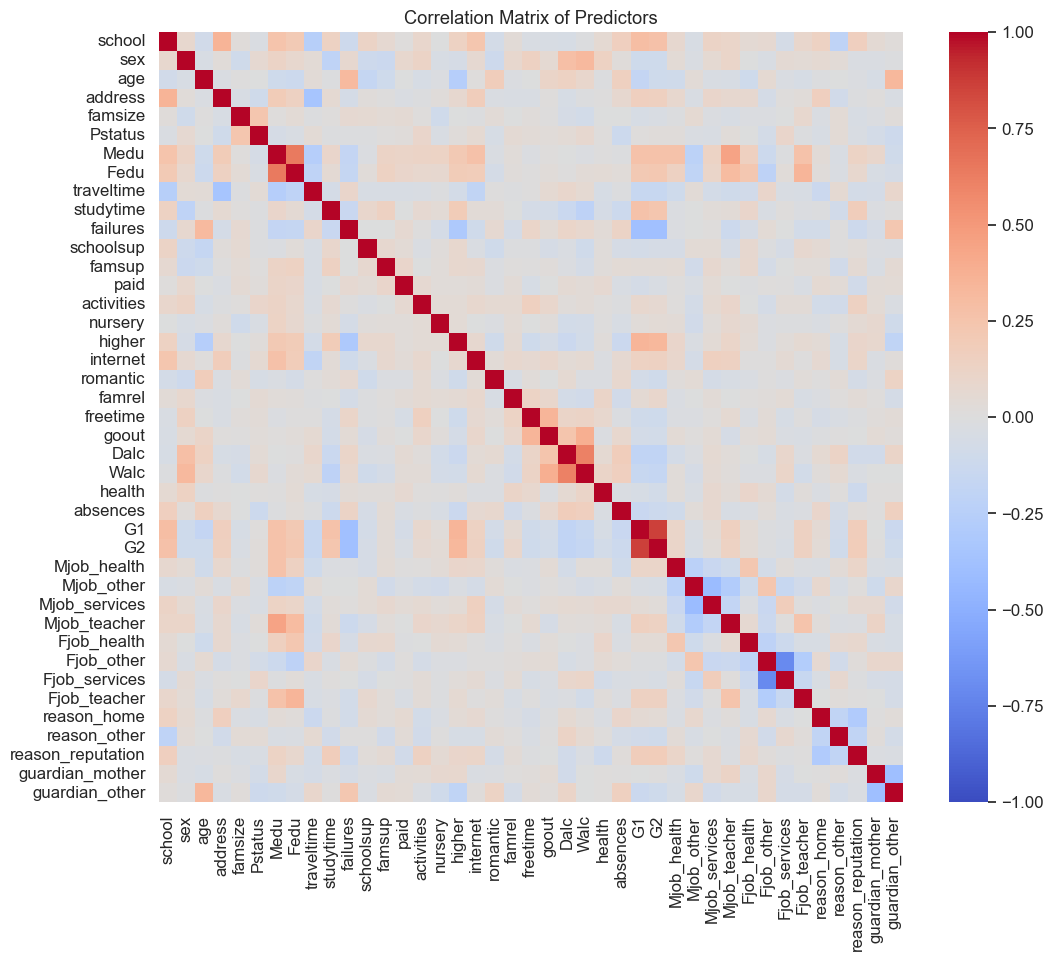

In [262]:
# ----------------- Correlation Matrix for Predictors ----------------

# Temporarily encode nominal categorical variables using one-hot encoding
df_encoded = df.copy()
df_encoded = pd.get_dummies(df_encoded, columns=nom_vars, drop_first=True)

# Convert any boolean columns to int
bool_cols = df_encoded.select_dtypes(include='bool').columns
df_encoded[bool_cols] = df_encoded[bool_cols].astype(int)

# Drop target variable to get predictors only
X = df_encoded.drop(columns='G3')  # predictors only

plt.figure(figsize=(12,10))
sns.heatmap(
    X.corr(),
    cmap="coolwarm",
    vmin=-1, vmax=1,
    annot=False
)
plt.title("Correlation Matrix of Predictors")
plt.show()

**Observations:**

- High correlation between G1 and G2 may indicate multicollinearity.

- Helps guide feature selection and VIF checks later.

## 3.6 Association Strength for Categorical Variables

We compute Pearson correlations for binary and eta-squared for multi-category features:

In [263]:
# ----------------- Association Strength for Categorical Variables ----------------

# Identify categorical variables
categorical_cols = df[cat_vars]

results = []

for col in cat_vars:  # assuming cat_vars is a list of categorical column names
    unique_vals = df[col].dropna().unique()

    # Binary variable → use Pearson (point-biserial)
    if len(unique_vals) == 2 and set(unique_vals).issubset({0, 1}):
        corr, pval = pearsonr(df[col], df['G3'])
        results.append({
            'Variable': col,
            'Type': 'Binary',
            'Correlation': corr,
            'p-value': pval
        })

    # Multi-category variable → use eta-squared (from ANOVA)
    elif len(unique_vals) > 2:
        groups = [df.loc[df[col] == val, 'G3'].dropna() for val in unique_vals]
        f_stat, pval = f_oneway(*groups)
        ss_between = sum(len(g) * (g.mean() - df['G3'].mean())**2 for g in groups)
        ss_total = sum((df['G3'] - df['G3'].mean())**2)
        eta_sq = ss_between / ss_total if ss_total != 0 else np.nan
        results.append({'Variable': col, 'Type': 'Multi-Category', 'Correlation': eta_sq, 'p-value': pval})

# Convert to DataFrame and sort
results_df = pd.DataFrame(results)
results_df['|Correlation|'] = results_df['Correlation'].abs()
results_df = results_df.sort_values(by='|Correlation|', ascending=False)

print("📊 Strength of association between categorical variables and G3:")
print(results_df[['Variable', 'Type', 'Correlation', 'p-value']])

📊 Strength of association between categorical variables and G3:
      Variable            Type  Correlation       p-value
10      higher          Binary     0.332172  3.499660e-18
0       school          Binary     0.284294  1.566199e-13
17    failures  Multi-Category     0.192900  8.644516e-30
2      address          Binary     0.167637  1.764153e-05
11    internet          Binary     0.150025  1.248917e-04
1          sex          Binary    -0.129077  9.815287e-04
12    romantic          Binary    -0.090583  2.100247e-02
16   studytime  Multi-Category     0.068765  5.705728e-10
5    schoolsup          Binary    -0.066405  9.097104e-02
13        Medu  Multi-Category     0.062669  1.885685e-08
8   activities          Binary     0.059791  1.280991e-01
6       famsup          Binary     0.059206  1.318865e-01
7         paid          Binary    -0.054898  1.624412e-01
14        Fedu  Multi-Category     0.048595  1.799114e-06
21        Dalc  Multi-Category     0.048425  1.898967e-06
26      

**Observations:**

## 3.7 Numeric Variable Correlations

In [264]:
# ----------------- 7. Strength of Association for Numeric (Continuos) Variables ----------------

#  Numeric variables: Pearson correlation with G3
# Dictionary to store results
numeric_results = {}

for col in cont_vars:  # list of numeric predictors
    corr, pval = pearsonr(df[col], df['G3'])
    numeric_results[col] = {'Correlation': corr, 'p-value': pval}

# Convert to DataFrame
numeric_corr_df = pd.DataFrame(numeric_results).T  # transpose so variables are rows
numeric_corr_df = numeric_corr_df.sort_values(by='Correlation', key=abs, ascending=False)  # sort by absolute correlation

print(numeric_corr_df)

          Correlation        p-value
G3           1.000000   0.000000e+00
G2           0.918548  5.642401e-263
G1           0.826387  1.617571e-163
age         -0.106505   6.612115e-03
absences    -0.091379   1.989562e-02


**Observations:**

## 3.8 Combined Strength of Associastion Plot

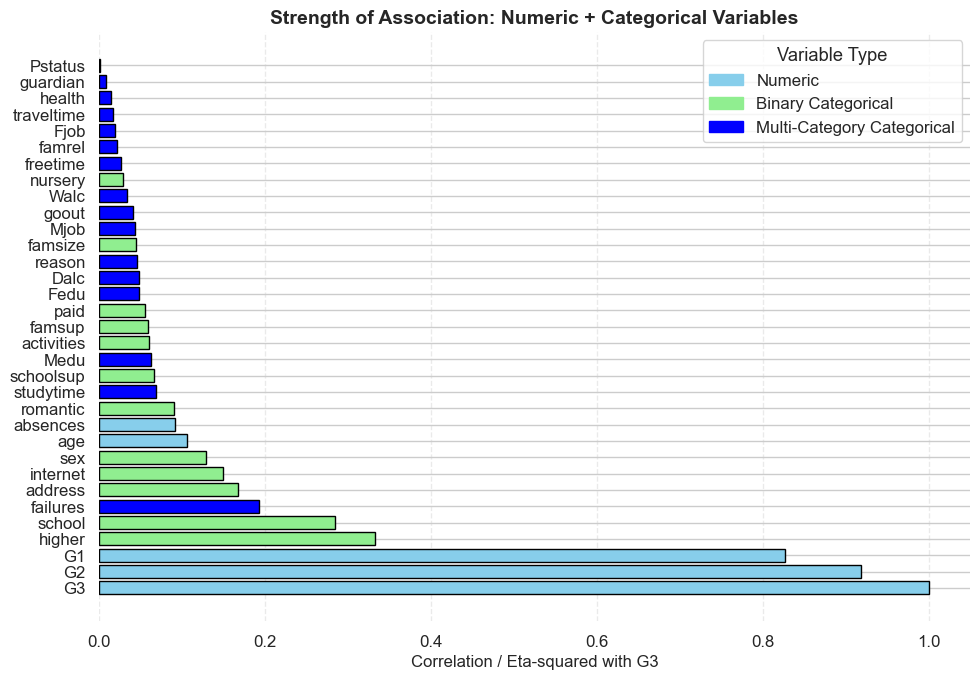

In [265]:
#  ----------------- 8. Visualization: Combined Bar Plot of Numeric + Categorical Associations ------------------

# Convert numeric_corr_df to match structure of results_df
numeric_plot_df = numeric_corr_df.copy()
numeric_plot_df['Variable'] = numeric_plot_df.index
numeric_plot_df['Type'] = 'Numeric'
numeric_plot_df = numeric_plot_df.reset_index(drop=True)

categorical_plot_df = results_df.copy()
categorical_plot_df = categorical_plot_df.rename(columns={'Correlation': 'Correlation', 'Variable': 'Variable'})
categorical_plot_df['Type'] = categorical_plot_df['Type']

# Combine
combined_df = pd.concat([numeric_plot_df[['Variable', 'Type', 'Correlation']], 
                         categorical_plot_df[['Variable', 'Type', 'Correlation']]])

# Sort for plotting
combined_df['Correlation'] = combined_df['Correlation'].abs()
combined_df = combined_df.sort_values(by='Correlation', key=abs, ascending=True)

# Colors
colors = combined_df['Type'].map({'Numeric': 'skyblue', 'Binary': 'lightgreen', 'Multi-Category': 'blue'})

# Create legend patches
legend_patches = [
    mpatches.Patch(color='skyblue', label='Numeric'),
    mpatches.Patch(color='lightgreen', label='Binary Categorical'),
    mpatches.Patch(color='blue', label='Multi-Category Categorical')
]

# Plot
sns.set_theme(style="whitegrid", palette="muted", font_scale=1.1)

plt.figure(figsize=(10, 7))
plt.barh(
    combined_df['Variable'], 
    combined_df['Correlation'], 
    color=colors,
    edgecolor='black'
)
plt.xlabel('Correlation / Eta-squared with G3', fontsize=12)
plt.title('Strength of Association: Numeric + Categorical Variables', fontsize=14, weight='bold')
plt.gca().invert_yaxis()  # strongest on top
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.legend(handles=legend_patches, title='Variable Type', loc='upper right')  
plt.tight_layout()
sns.despine(left=True, bottom=True)
plt.show()

**Explanation:**

- Shows the absolute correlation / eta-squared values across all variables.

- Facilitates quick identification of the most influential features.

## Inferential Statistics

In [266]:
# ------------------ Inferential Statistics ------------------

alpha = 0.05  # significance threshold

# ================= 1. T-tests for Binary Categorical vs Continuous =================

t_results = []

for var in bin_vars:  # binary predictors
    for col in cont_vars:  # continuous outcomes
        group0 = df[df[var] == 0][col]
        group1 = df[df[var] == 1][col]

        # Variance ratio
        var0 = np.var(group0, ddof=1)
        var1 = np.var(group1, ddof=1)
        ratio = max(var0, var1) / min(var0, var1)

        # Choose t-test type
        if ratio > 1.5:
            t_stat, p_val = ttest_ind(group0, group1, equal_var=False)
            test_type = "Welch's t-test"
        else:
            t_stat, p_val = ttest_ind(group0, group1, equal_var=True)
            test_type = "Student's t-test"

        # Effect size (Cohen's d)
        mean_diff = group1.mean() - group0.mean()
        pooled_sd = np.sqrt((var0 + var1) / 2)
        cohens_d = mean_diff / pooled_sd

        # Append results
        t_results.append({
            "Group Variable": var,
            "Numeric Variable": col,
            "Test Type": test_type,
            "t-statistic": round(t_stat, 3),
            "p-value": round(p_val, 5),
            "Variance Ratio": round(ratio, 2),
            "Group0 Mean": round(group0.mean(), 2),
            "Group1 Mean": round(group1.mean(), 2),
            "Cohen's d": round(cohens_d, 3)
        })

# Convert to DataFrame
t_results_df = pd.DataFrame(t_results)
t_results_df = t_results_df.sort_values("p-value").reset_index(drop=True)

print(f"Significant t-test results (p < {alpha}):")
display(t_results_df[t_results_df["p-value"] < alpha])


# ================= 2. ANOVA for Multi-level Categorical vs Continuous =================

anova_results = []

for var in ord_vars:  # ordinal or multi-level categorical predictors
    for col in cont_vars:
        groups = [df[df[var] == level][col] for level in df[var].dropna().unique()]
        if len(groups) < 2:
            continue  # skip if only one group present
        f_stat, p_val = f_oneway(*groups)
        
        # Effect size: eta-squared
        ss_between = sum(len(g)*(g.mean() - df[col].mean())**2 for g in groups)
        ss_total = sum((df[col] - df[col].mean())**2)
        eta_sq = ss_between / ss_total if ss_total != 0 else np.nan

        anova_results.append({
            "Categorical Variable": var,
            "Numeric Variable": col,
            "F-statistic": round(f_stat, 3),
            "p-value": round(p_val, 5),
            "Eta-squared": round(eta_sq, 3)
        })

anova_df = pd.DataFrame(anova_results)
anova_df = anova_df.sort_values("p-value").reset_index(drop=True)

print(f"Significant ANOVA results (p < {alpha}):")
display(anova_df[anova_df["p-value"] < alpha])


# ================= 3. Chi-square Tests for Categorical Variables =================

chi2_results = []

for i in range(len(cat_vars)):
    for j in range(i+1, len(cat_vars)):
        var1 = cat_vars[i]
        var2 = cat_vars[j]

        # Contingency table
        table = pd.crosstab(df[var1], df[var2])
        chi2, p_val, dof, expected = chi2_contingency(table)

        # Cramer's V effect size
        n = table.sum().sum()
        min_dim = min(table.shape) - 1
        cramers_v = np.sqrt(chi2 / (n * min_dim)) if min_dim > 0 else np.nan

        chi2_results.append({
            "Variable 1": var1,
            "Variable 2": var2,
            "Chi2": round(chi2, 3),
            "p-value": round(p_val, 5),
            "dof": dof,
            "Cramer's V": round(cramers_v, 3)
        })

chi2_df = pd.DataFrame(chi2_results)
chi2_df = chi2_df.sort_values("p-value").reset_index(drop=True)

print(f"Significant Chi-square results (p < {alpha}):")
display(chi2_df[chi2_df["p-value"] < alpha])


Significant t-test results (p < 0.05):


,Group Variable,Numeric Variable,Test Type,t-statistic,p-value,Variance Ratio,Group0 Mean,Group1 Mean,Cohen's d
0,school,absences,Welch's t-test,-4.876,0.00000,2.75,2.62,4.22,0.372
1,school,G1,Welch's t-test,-7.311,0.00000,1.52,10.30,11.99,0.621
2,school,G2,Welch's t-test,-6.484,0.00000,1.90,10.50,12.14,0.559
3,school,G3,Welch's t-test,-6.754,0.00000,2.13,10.65,12.58,0.586
4,romantic,age,Student's t-test,-4.623,0.00000,1.17,16.58,17.03,0.372
5,higher,age,Student's t-test,7.005,0.00000,1.33,17.68,16.63,-0.840
6,higher,G1,Welch's t-test,-12.434,0.00000,2.01,8.62,11.73,1.357
7,higher,G2,Student's t-test,-8.951,0.00000,1.28,8.77,11.90,1.195
8,higher,G3,Student's t-test,-8.958,0.00000,1.06,8.80,12.28,1.153
9,schoolsup,age,Student's t-test,4.331,0.00002,1.08,16.81,16.15,-0.563


Significant ANOVA results (p < 0.05):


,Categorical Variable,Numeric Variable,F-statistic,p-value,Eta-squared
0,failures,age,27.777,0.00000,0.114
1,studytime,G3,15.876,0.00000,0.069
2,failures,G1,46.178,0.00000,0.177
3,failures,G2,48.598,0.00000,0.184
4,failures,G3,51.386,0.00000,0.193
5,Fedu,G3,8.223,0.00000,0.049
6,studytime,G2,14.454,0.00000,0.063
7,Fedu,G2,9.085,0.00000,0.053
8,Dalc,G3,8.193,0.00000,0.048
9,Medu,G3,10.764,0.00000,0.063


Significant Chi-square results (p < 0.05):


,Variable 1,Variable 2,Chi2,p-value,dof,Cramer's V
0,Dalc,Walc,442.393,0.00000,16,0.413
1,higher,studytime,34.300,0.00000,3,0.230
2,school,Mjob,37.876,0.00000,4,0.242
3,school,reason,52.524,0.00000,3,0.284
4,higher,Medu,30.594,0.00000,4,0.217
...,...,...,...,...,...,...
115,school,sex,4.129,0.04216,1,0.080
116,Medu,guardian,15.925,0.04347,8,0.111
117,activities,internet,4.022,0.04490,1,0.079
118,romantic,Dalc,9.642,0.04692,4,0.122


# Modeling

## Checking Model Assumptions

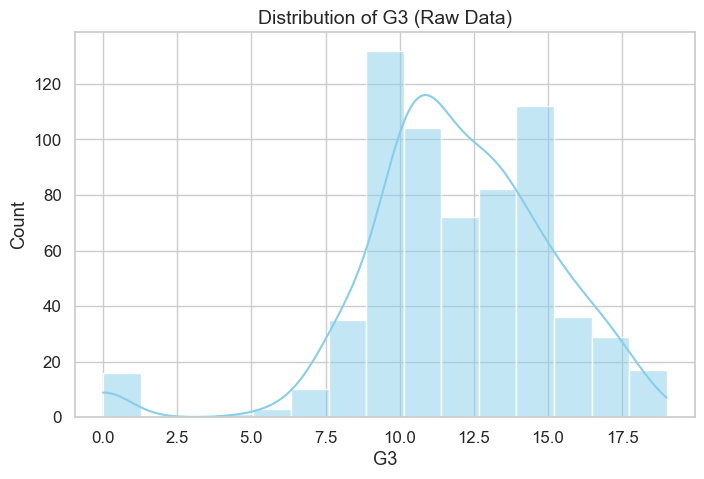

Raw skewness: -0.91 | Raw kurtosis: 2.71
Shapiro–Wilk (raw): W = 0.926, p = 0.0000

Number of potential outliers: 16


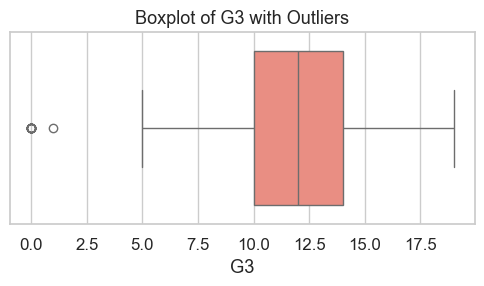

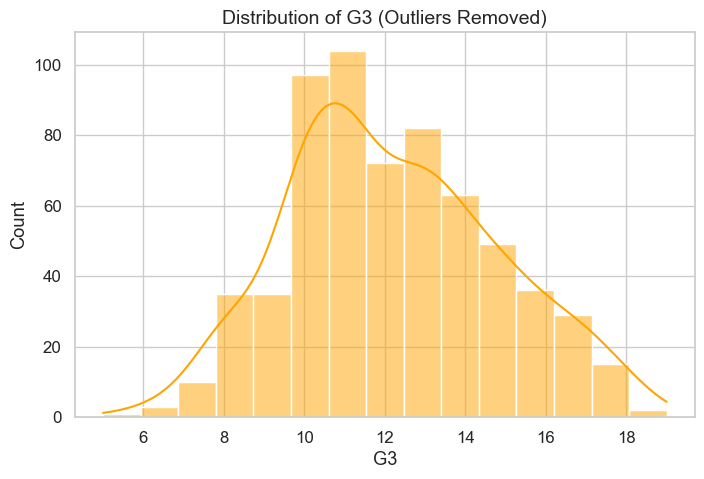

After removing outliers: skewness = 0.23, kurtosis = -0.47
Shapiro–Wilk (no outliers): W = 0.976, p = 0.0000


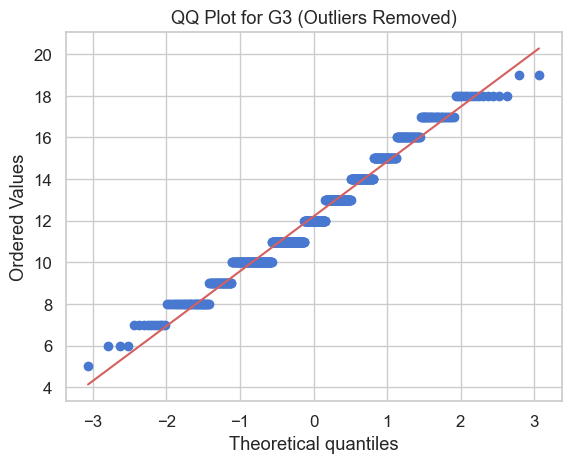

In [267]:
# ------------------ 1. Check Model Assumptions for Target Variable (G3) ------------------

target = 'G3'

# --- 1.1 Distribution and Normality (Raw) ---
plt.figure(figsize=(8,5))
sns.histplot(df[target], kde=True, color='skyblue', bins=15)
plt.title(f"Distribution of {target} (Raw Data)", fontsize=14)
plt.xlabel(target)
plt.ylabel("Count")
plt.show()

# Skewness and kurtosis (raw)
skew_val_raw = df[target].skew()
kurt_val_raw = df[target].kurtosis()
print(f"Raw skewness: {skew_val_raw:.2f} | Raw kurtosis: {kurt_val_raw:.2f}")

# Shapiro–Wilk test (raw)
shapiro_stat, shapiro_p = stats.shapiro(df[target])
print(f"Shapiro–Wilk (raw): W = {shapiro_stat:.3f}, p = {shapiro_p:.4f}")


# --- 1.2 Outlier Detection (IQR method) ---
Q1 = df[target].quantile(0.25)
Q3 = df[target].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df[target] < lower_bound) | (df[target] > upper_bound)]
print(f"\nNumber of potential outliers: {len(outliers)}")

# Boxplot visualization
plt.figure(figsize=(6,2.5))
sns.boxplot(x=df[target], color='salmon')
plt.title(f"Boxplot of {target} with Outliers", fontsize=13)
plt.show()

# Remove outliers
df_no_outliers = df[(df[target] >= lower_bound) & (df[target] <= upper_bound)]


# --- 1.3 Distribution and Normality (Outliers Removed) ---
plt.figure(figsize=(8,5))
sns.histplot(df_no_outliers[target], kde=True, color='orange', bins=15)
plt.title(f"Distribution of {target} (Outliers Removed)", fontsize=14)
plt.show()

# Skewness and kurtosis (after outlier removal)
skew_val = df_no_outliers[target].skew()
kurt_val = df_no_outliers[target].kurtosis()
print(f"After removing outliers: skewness = {skew_val:.2f}, kurtosis = {kurt_val:.2f}")

# Shapiro–Wilk (after outlier removal)
shapiro_stat, shapiro_p = stats.shapiro(df_no_outliers[target])
print(f"Shapiro–Wilk (no outliers): W = {shapiro_stat:.3f}, p = {shapiro_p:.4f}")

# QQ plot for visual check

stats.probplot(df_no_outliers[target], dist="norm", plot=plt)
plt.title(f"QQ Plot for {target} (Outliers Removed)")
plt.show()


In [268]:
# ------------------ 2. Check Multicollinearity (VIF) ------------------

# Select numeric predictors only
X = df_no_outliers[numeric_vars].drop(columns=['G3'], errors='ignore')
X = sm.add_constant(X)

vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

display(vif_data.sort_values(by="VIF", ascending=False))

,Variable,VIF
0,const,290.717915
4,G2,4.873412
3,G1,4.770796
14,Walc,1.908393
5,Medu,1.845610
6,Fedu,1.761686
13,Dalc,1.699019
12,goout,1.355849
9,failures,1.306955
1,age,1.214999


In [269]:
# ------------------ 3. Recompute VIF for All Predictors with One-hot Encoded Multi-category Predictors ------------------

# X = predictors only (after one-hot encoding)
X = df_encoded.drop(columns=['G3'])
X = sm.add_constant(X)  # add intercept

# Compute VIF
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Sort descending for readability
vif_data = vif_data.sort_values(by="VIF", ascending=False).reset_index(drop=True)
display(vif_data)

,Variable,VIF
0,const,378.218504
1,Fjob_other,4.677847
2,G1,4.430493
3,G2,4.307080
4,Fjob_services,4.227396
5,Medu,2.693316
6,Mjob_teacher,2.277617
7,Fjob_teacher,2.178296
8,Walc,2.113194
9,Mjob_services,2.113154


Significant variables (p < 0.05):
age              8.463269e-04
traveltime       1.557441e-02
failures         1.657705e-02
higher           1.894668e-02
absences         4.119882e-02
G1               2.926762e-11
G2               1.306312e-99
Fjob_other       1.678581e-02
Fjob_services    1.960132e-02
dtype: float64

Confidence intervals:
                      0         1
age            0.046101  0.176338
traveltime     0.023300  0.221490
failures      -0.296672 -0.029813
higher         0.048840  0.541920
absences      -0.032148 -0.000657
G1             0.134410  0.244046
G2             0.681596  0.793274
Fjob_other    -0.632590 -0.062966
Fjob_services -0.656782 -0.057417
                            OLS Regression Results                            
Dep. Variable:                     G3   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     140.9
Da

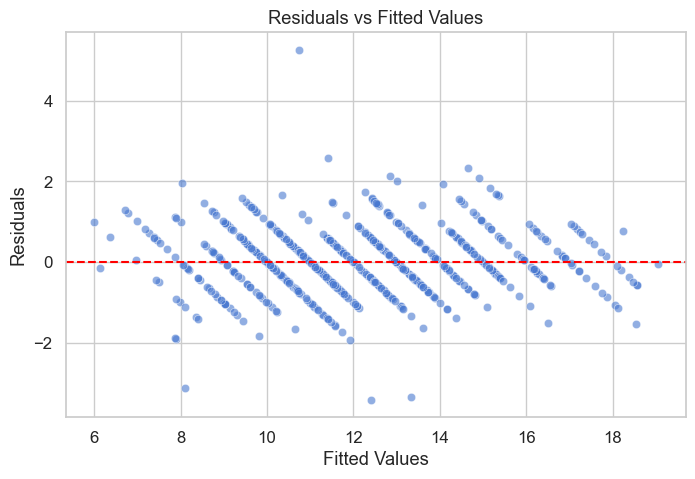

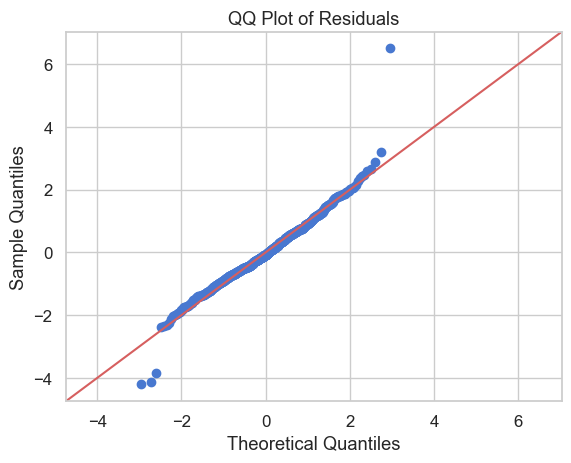

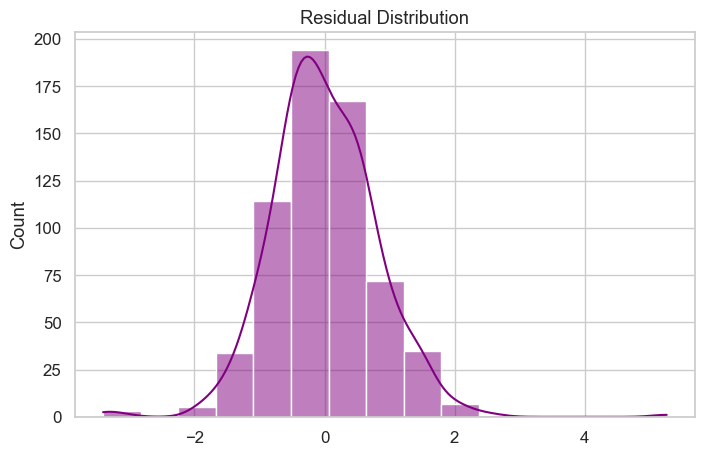

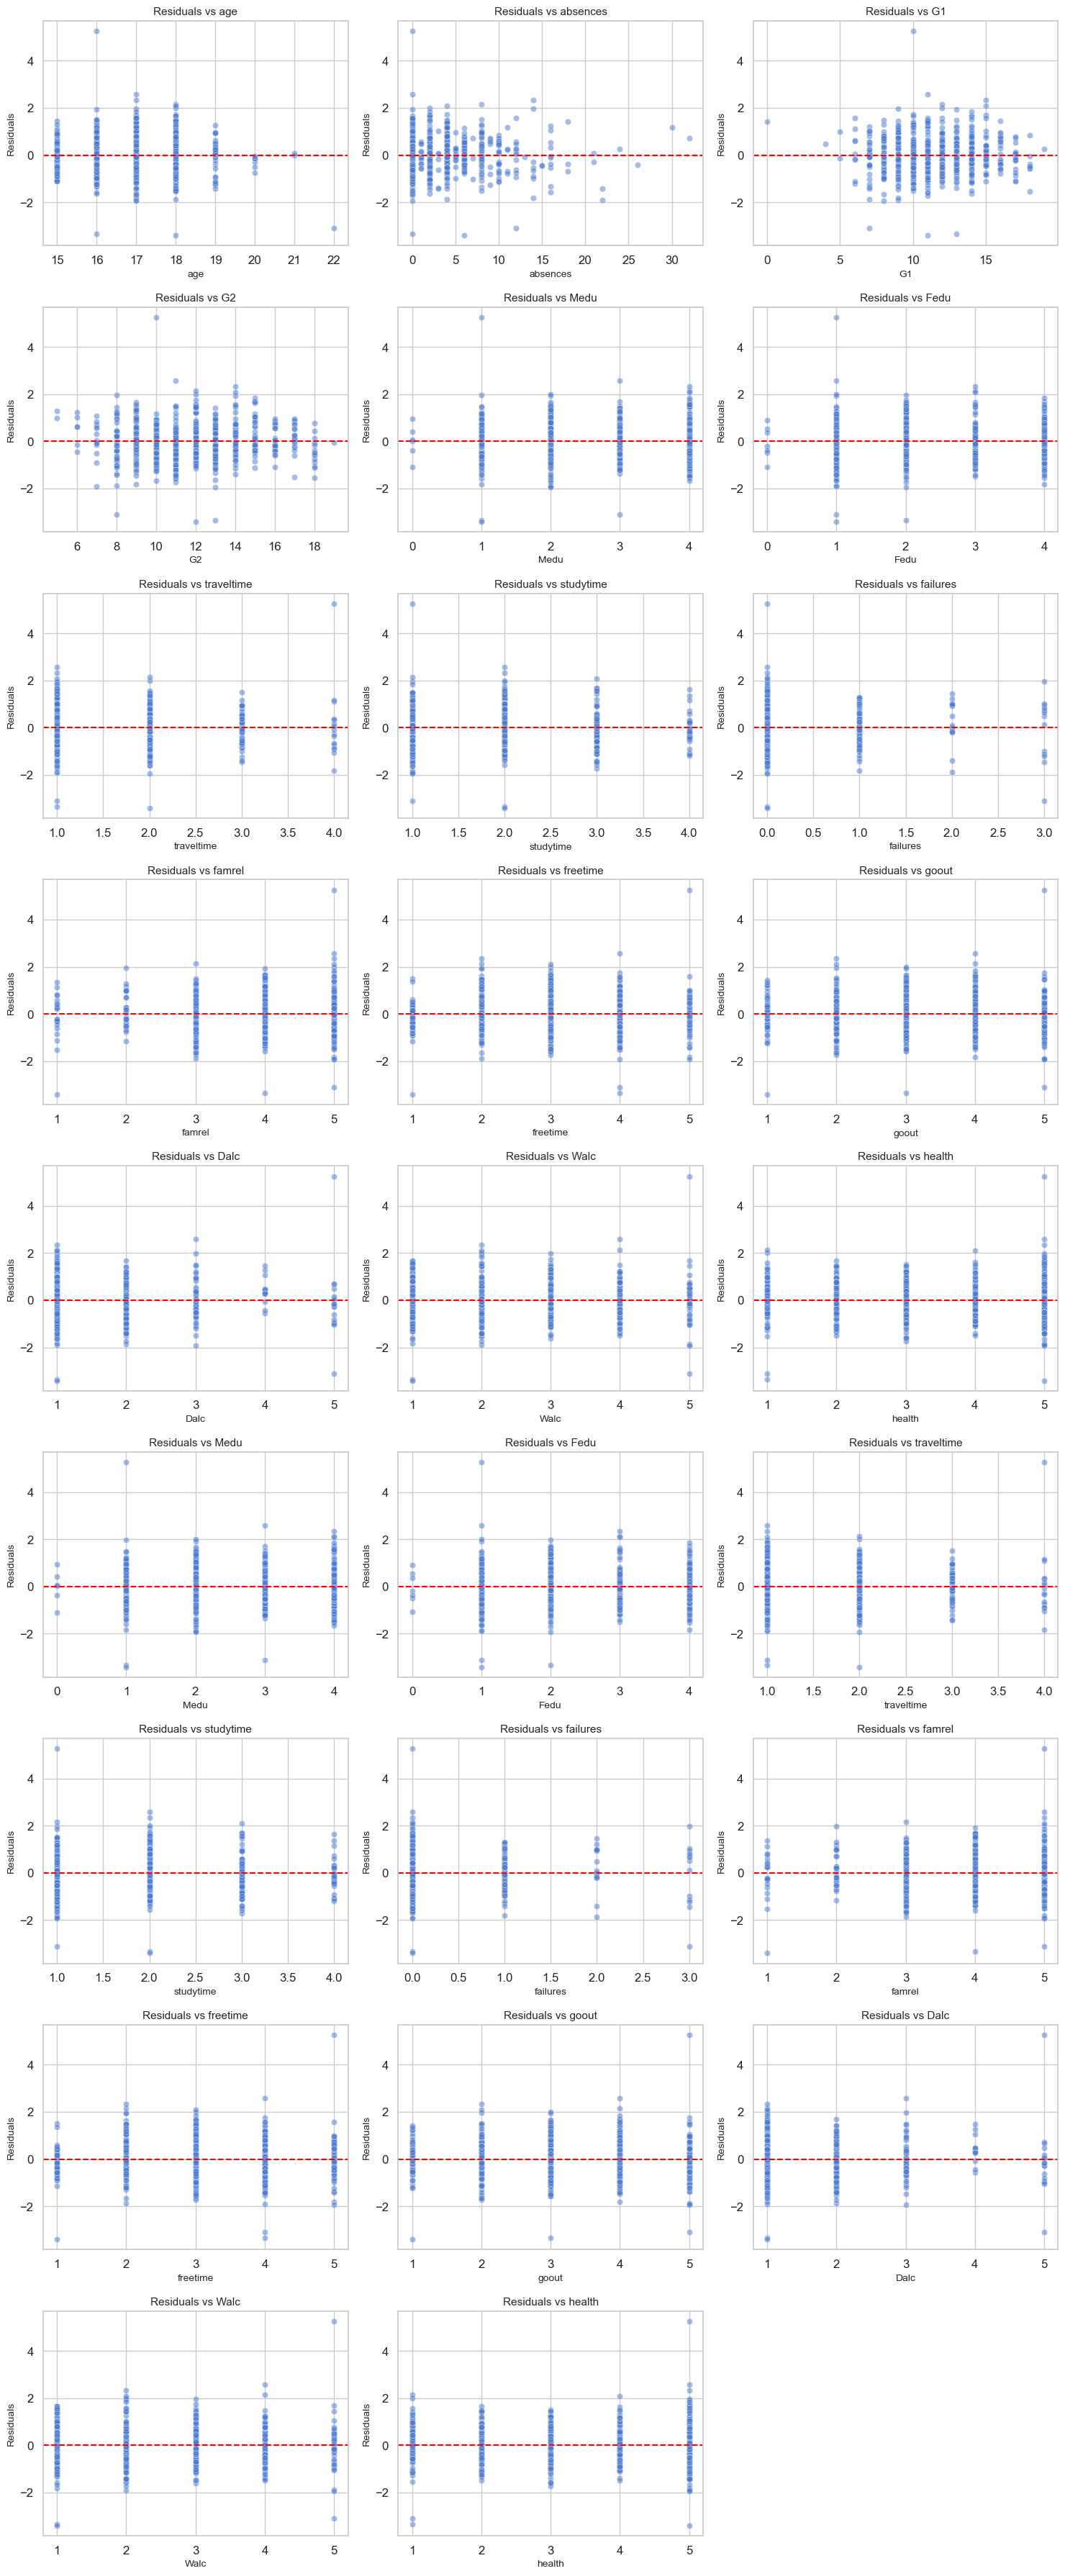

In [270]:
# ------------------ 4. Fit Preliminary OLS Model to Check Residuals ------------------

# Predictors (with one-hot encoding) and target
X = df_encoded.drop(columns=['G3'])
X = sm.add_constant(X)              # add intercept
y = df_no_outliers['G3']            # remove outliers

# Fit model
prelim_model = sm.OLS(y, X.loc[y.index]).fit()  # align indices since using outlier-cleaned y

# Residuals
residuals = prelim_model.resid
fitted = prelim_model.fittedvalues

# Significant predictors at alpha = 0.05
significant_vars = prelim_model.pvalues[prelim_model.pvalues < 0.05]
print("Significant variables (p < 0.05):")
print(significant_vars)

# Optional: confidence intervals
conf_int = prelim_model.conf_int()
print("\nConfidence intervals:")
print(conf_int.loc[significant_vars.index])

# Summary
print(prelim_model.summary())

# ---------------- Residual Plots ----------------

plt.figure(figsize=(8,5))
sns.scatterplot(x=fitted, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted Values")
plt.show()

# QQ Plot of residuals
sm.qqplot(residuals, line='45', fit=True)
plt.title("QQ Plot of Residuals")
plt.show()

# Histogram of residuals
plt.figure(figsize=(8,5))
sns.histplot(residuals, kde=True, color='purple', bins=15)
plt.title("Residual Distribution")
plt.show()

# --------- Residuals vs Predictors Plots ---------

# Combine numeric (excluding target) and ordinal predictors
predictors_to_check = [col for col in numeric_vars if col != 'G3'] + ord_vars

n_preds = len(predictors_to_check)
n_cols = 3
n_rows = int(np.ceil(n_preds / n_cols))

plt.figure(figsize=(n_cols*5, n_rows*4))

for i, col in enumerate(predictors_to_check):
    plt.subplot(n_rows, n_cols, i+1)
    
    # For ordinal predictors, jitter slightly for visibility
    x = df_encoded[col] if col in numeric_vars else df_encoded[col] + np.random.normal(0, 0.05, size=len(df_encoded))
    
    sns.scatterplot(x=x, y=residuals, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel(col, fontsize=10)
    plt.ylabel('Residuals', fontsize=10)
    plt.title(f'Residuals vs {col}', fontsize=11)

plt.tight_layout()
plt.show()

In [271]:
#  --------------- Test for Heteroscedasticity (Breusch-Pagan) ------------------

# Residuals and predictors from preliminary OLS model
lm = prelim_model  # your OLS model

# Run Breusch-Pagan test
bp_test = het_breuschpagan(lm.resid, lm.model.exog)
bp_labels = ['LM Statistic', 'LM p-value', 'F-Statistic', 'F p-value']

print("Breusch-Pagan Test for Heteroscedasticity:")
for label, value in zip(bp_labels, bp_test):
    print(f"{label}: {value:.4f}")

Breusch-Pagan Test for Heteroscedasticity:
LM Statistic: 67.3687
LM p-value: 0.0058
F-Statistic: 1.7168
F p-value: 0.0043


Null hypothesis rejected, use robust standard errors in OLS and try models that aren’t sensitive to heteroscedasticity, like tree-based methods (Random Forest, Gradient Boosting).

### Feature Engineering

In [272]:
# ------------------- Feature Engineering & Interaction Terms (Test OLS) -------------------
X_test_fe = df_encoded.drop(columns=['G3']).copy()
y_test_fe = df_no_outliers['G3']
X_test_fe = X_test_fe.loc[y_test_fe.index]

# 1. Performance improvement (abs difference between G1 and G2)
X_test_fe['G_perf_improve'] = abs(df_no_outliers['G2'] - df_no_outliers['G1'])

# 2. Interaction term (studytime * failures)
if 'studytime' in X_test_fe.columns and 'failures' in X_test_fe.columns:
    X_test_fe['studytime_failures'] = X_test_fe['studytime'] * X_test_fe['failures']

# Average past performance (G1 + G2)/2
X_test_fe['G_avg'] = (df_no_outliers['G1'] + df_no_outliers['G2']) / 2

# Attendance impact (absences * studytime)
if 'absences' in X_test_fe.columns and 'studytime' in X_test_fe.columns:
    X_test_fe['absences_studytime'] = X_test_fe['absences'] * X_test_fe['studytime']

# ------------------- Train/Test Split -------------------
X_train_fe, X_test_fe, y_train_fe, y_test_fe = train_test_split(
    X_test_fe, y_test_fe, test_size=0.2, random_state=42
)

# ------------------- OLS: Baseline -------------------
X_sm_base = sm.add_constant(X_train_fe.drop(columns=['G_perf_improve','studytime_failures','G_avg','absences_studytime']))
ols_base = sm.OLS(y_train_fe, X_sm_base).fit()
y_pred_base = ols_base.predict(sm.add_constant(X_test_fe.drop(columns=['G_perf_improve','studytime_failures','G_avg','absences_studytime'])))

print("Baseline OLS Test R2:", r2_score(y_test_fe, y_pred_base))
print("Baseline OLS Test RMSE:", mean_squared_error(y_test_fe, y_pred_base) ** 0.5)

# ------------------- OLS: With Feature-Engineered Terms -------------------
X_sm_fe = sm.add_constant(X_train_fe)
ols_fe = sm.OLS(y_train_fe, X_sm_fe).fit()
y_pred_fe = ols_fe.predict(sm.add_constant(X_test_fe))

print("FE OLS Test R2:", r2_score(y_test_fe, y_pred_fe))
print("FE OLS Test RMSE:", mean_squared_error(y_test_fe, y_pred_fe) ** 0.5)

Baseline OLS Test R2: 0.8949719417225516
Baseline OLS Test RMSE: 0.8717123735429568
FE OLS Test R2: 0.8940081828334323
FE OLS Test RMSE: 0.8757027456172531


No strong evidence that these specific FE/interactions improve the model

### Comparing Models

,Model,Train_RMSE,Test_RMSE,Train_R2,Test_R2
0,OLS,0.800243,0.871712,0.908518,0.894972
1,Lasso,0.848957,0.890324,0.897041,0.890439
2,Ridge,0.802309,0.877693,0.908045,0.893526
3,Random Forest,0.334208,0.861520,0.984044,0.897414
4,Gradient Boosting,0.425179,0.868352,0.974175,0.895780


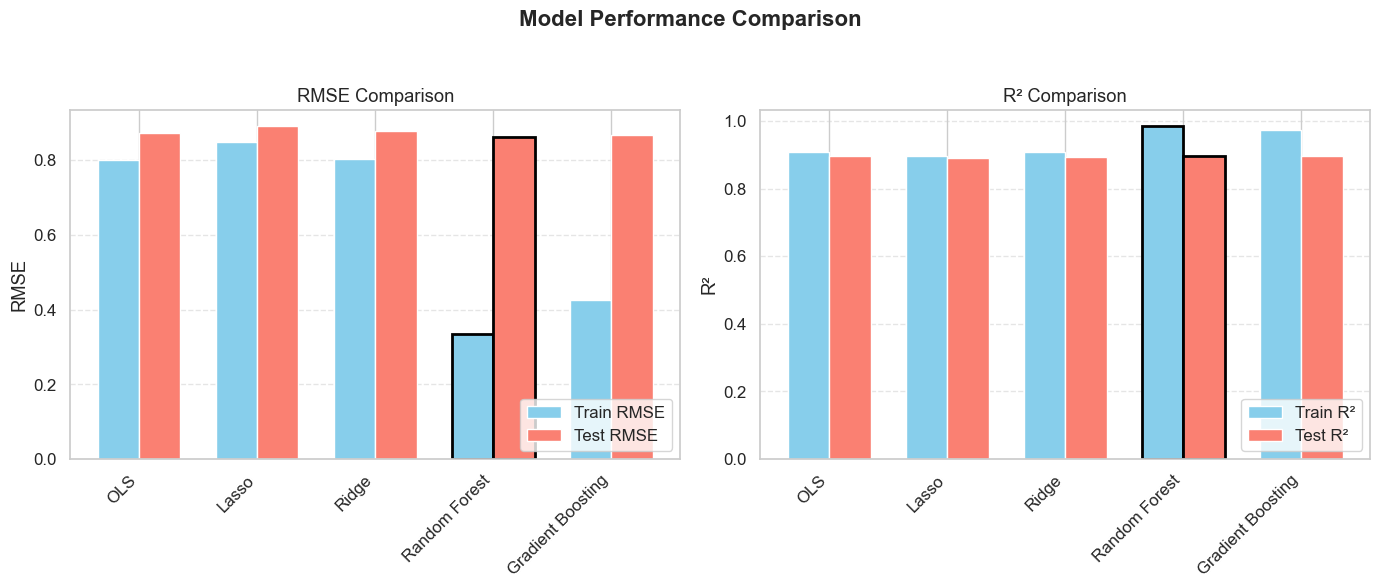

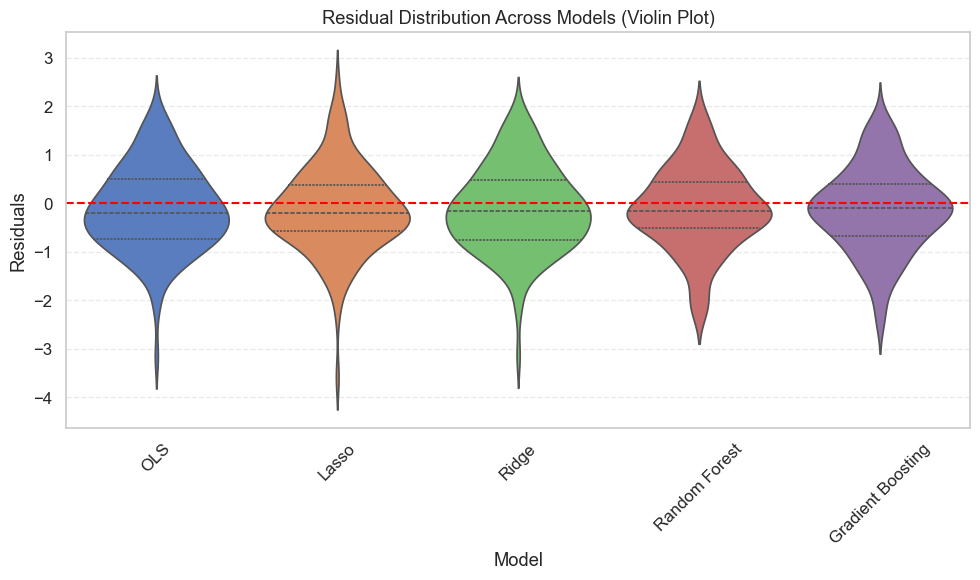

In [273]:
# ------------------- Data -------------------
X = df_encoded.drop(columns=['G3'])
y = df_no_outliers['G3']  # keep outlier removal
X = X.loc[y.index]

# Train/test split with random seed for reproducibility
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize results container 
results = []

# ------------------- 1. Scaled OLS -------------------

# Scale features
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled  = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

# Add constant for intercept
X_train_scaled = sm.add_constant(X_train_scaled)
X_test_scaled  = sm.add_constant(X_test_scaled)

# Fit OLS on scaled features
ols_model = sm.OLS(y_train, X_train_scaled).fit(cov_type='HC3') # robust SEs

# Predictions
y_pred_train_ols = ols_model.predict(X_train_scaled)
y_pred_test_ols  = ols_model.predict(X_test_scaled)

results.append({
    "Model": "OLS",
    "Train_RMSE": mean_squared_error(y_train, y_pred_train_ols) ** 0.5,
    "Test_RMSE": mean_squared_error(y_test, y_pred_test_ols) ** 0.5,
    "Train_R2": r2_score(y_train, y_pred_train_ols),
    "Test_R2": r2_score(y_test, y_pred_test_ols)
})

# ------------------- 2. Lasso -------------------
lasso_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', Lasso(random_state=42))
])

param_grid = {'lasso__alpha': [0.001, 0.01, 0.1, 1, 10]}
grid_lasso = GridSearchCV(lasso_pipe, param_grid, cv=5, scoring='r2')
grid_lasso.fit(X_train, y_train)
best_lasso = grid_lasso.best_estimator_

y_pred_train_lasso = best_lasso.predict(X_train)
y_pred_test_lasso  = best_lasso.predict(X_test)

results.append({
    "Model": "Lasso",
    "Train_RMSE": mean_squared_error(y_train, y_pred_train_lasso) ** 0.5,
    "Test_RMSE": mean_squared_error(y_test, y_pred_test_lasso) ** 0.5,
    "Train_R2": r2_score(y_train, y_pred_train_lasso),
    "Test_R2": r2_score(y_test, y_pred_test_lasso)
})

# ------------------- 3. Ridge -------------------
ridge_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge(random_state=42))
])

param_grid = {'ridge__alpha': [0.01, 0.1, 1, 10, 100]}
grid_ridge = GridSearchCV(ridge_pipe, param_grid, cv=5, scoring='r2')
grid_ridge.fit(X_train, y_train)
best_ridge = grid_ridge.best_estimator_

y_pred_train_ridge = best_ridge.predict(X_train)
y_pred_test_ridge  = best_ridge.predict(X_test)

results.append({
    "Model": "Ridge",
    "Train_RMSE": mean_squared_error(y_train, y_pred_train_ridge) ** 0.5,
    "Test_RMSE": mean_squared_error(y_test, y_pred_test_ridge) ** 0.5,
    "Train_R2": r2_score(y_train, y_pred_train_ridge),
    "Test_R2": r2_score(y_test, y_pred_test_ridge)
})

# ------------------- 4. Random Forest -------------------
rf = RandomForestRegressor(random_state=42, n_estimators=200)
rf.fit(X_train, y_train)

y_pred_train_rf = rf.predict(X_train)
y_pred_test_rf  = rf.predict(X_test)

results.append({
    "Model": "Random Forest",
    "Train_RMSE": mean_squared_error(y_train, y_pred_train_rf) ** 0.5,
    "Test_RMSE": mean_squared_error(y_test, y_pred_test_rf) ** 0.5,
    "Train_R2": r2_score(y_train, y_pred_train_rf),
    "Test_R2": r2_score(y_test, y_pred_test_rf)
})

# ------------------- 5. Gradient Boosting -------------------
gb = GradientBoostingRegressor(random_state=42, n_estimators=200)
gb.fit(X_train, y_train)

y_pred_train_gb = gb.predict(X_train)
y_pred_test_gb  = gb.predict(X_test)

results.append({
    "Model": "Gradient Boosting",
    "Train_RMSE": mean_squared_error(y_train, y_pred_train_gb) ** 0.5,
    "Test_RMSE": mean_squared_error(y_test, y_pred_test_gb) ** 0.5,
    "Train_R2": r2_score(y_train, y_pred_train_gb),
    "Test_R2": r2_score(y_test, y_pred_test_gb)
})

# ------------------- Convert results to DataFrame -------------------
results_df = pd.DataFrame(results)
display(results_df)

# ------------------- Plot comparisons -------------------

# Determine the best model (lowest Test RMSE)
best_idx = results_df['Test_RMSE'].idxmin()

# Bar width and positions
x = np.arange(len(results_df['Model']))
width = 0.35

fig, axes = plt.subplots(1, 2, figsize=(14,6))

# Colors
train_color = 'skyblue'
test_color = 'salmon'
highlight_edge = 'black'

# RMSE Comparison
for i in range(len(x)):
    edge = highlight_edge if i == best_idx else None
    axes[0].bar(x[i] - width/2, results_df['Train_RMSE'][i], width=width, color=train_color, edgecolor=edge, linewidth=2 if edge else 1, label='Train RMSE' if i==0 else "")
    axes[0].bar(x[i] + width/2, results_df['Test_RMSE'][i], width=width, color=test_color, edgecolor=edge, linewidth=2 if edge else 1, label='Test RMSE' if i==0 else "")

axes[0].set_xticks(x)
axes[0].set_xticklabels(results_df['Model'], rotation=45, ha='right')
axes[0].set_title("RMSE Comparison")
axes[0].set_ylabel("RMSE")
axes[0].grid(axis='y', linestyle='--', alpha=0.5)
axes[0].legend(loc='lower right')

# R² Comparison
for i in range(len(x)):
    edge = highlight_edge if i == best_idx else None
    axes[1].bar(x[i] - width/2, results_df['Train_R2'][i], width=width, color=train_color, edgecolor=edge, linewidth=2 if edge else 1, label='Train R²' if i==0 else "")
    axes[1].bar(x[i] + width/2, results_df['Test_R2'][i], width=width, color=test_color, edgecolor=edge, linewidth=2 if edge else 1, label='Test R²' if i==0 else "")

axes[1].set_xticks(x)
axes[1].set_xticklabels(results_df['Model'], rotation=45, ha='right')
axes[1].set_title("R² Comparison")
axes[1].set_ylabel("R²")
axes[1].grid(axis='y', linestyle='--', alpha=0.5)
axes[1].legend(loc='lower right')

plt.suptitle("Model Performance Comparison", fontsize=16, weight='bold')
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()

# ---------------- Violin Plot ----------------
residuals_dict = {
    "OLS": y_test - y_pred_test_ols,
    "Lasso": y_test - y_pred_test_lasso,
    "Ridge": y_test - y_pred_test_ridge,
    "Random Forest": y_test - y_pred_test_rf,
    "Gradient Boosting": y_test - y_pred_test_gb
}

# Convert to long-form DataFrame for seaborn
residuals_df = pd.DataFrame(residuals_dict)
residuals_long = residuals_df.melt(var_name="Model", value_name="Residuals")

plt.figure(figsize=(10,6))
sns.violinplot(
    x="Model",
    y="Residuals",
    data=residuals_long,
    hue="Model",       # assign x to hue
    palette="muted",   # now allowed
    inner="quartile",
    legend=False       # hide extra legend
)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residual Distribution Across Models (Violin Plot)")
plt.ylabel("Residuals")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

### Interpreting Best Model

Best model selected based on Test RMSE: Random Forest


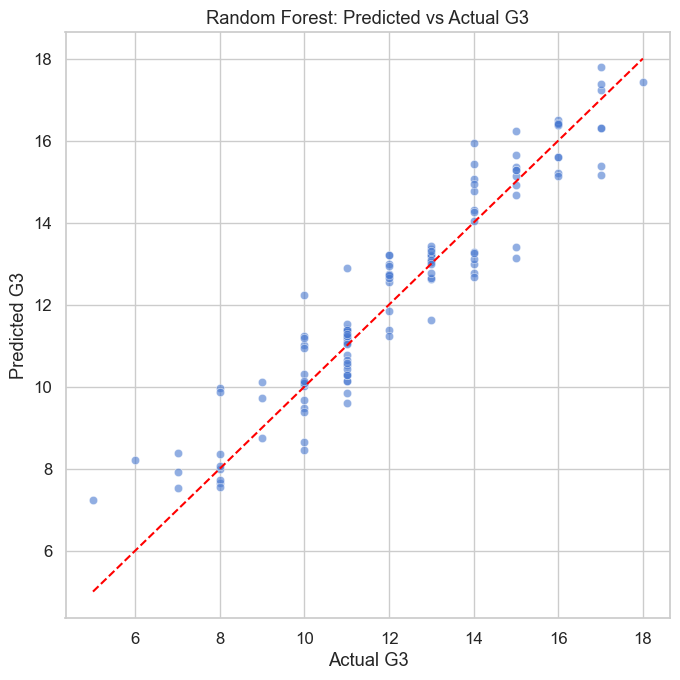

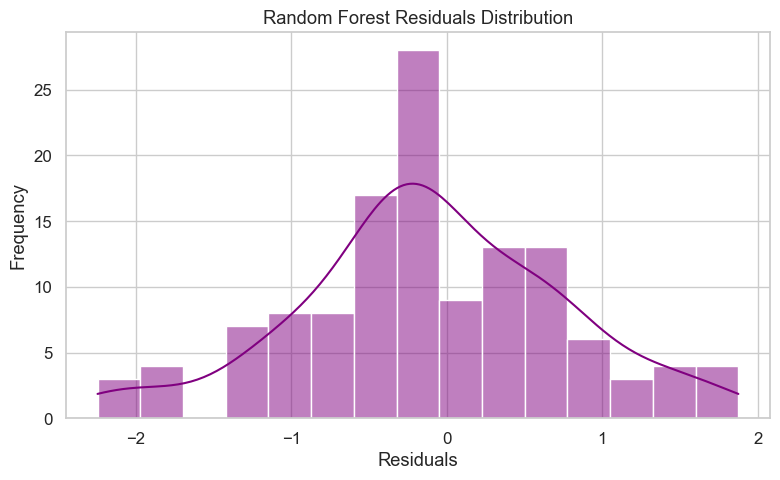

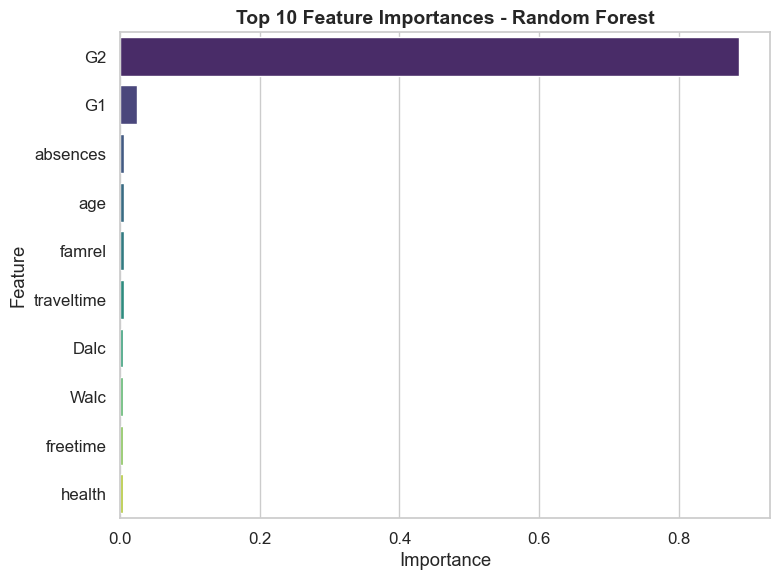

Top 10 important features:


G2            0.886439
G1            0.024254
absences      0.006254
age           0.005706
famrel        0.005571
traveltime    0.005500
Dalc          0.004274
Walc          0.004050
freetime      0.004038
health        0.004022
dtype: float64

In [274]:
# ------------------ Random Forest Interpretation ------------------

# Identify the best model index
best_idx = results_df['Test_RMSE'].idxmin()
best_model_name = results_df.loc[best_idx, 'Model']
print(f"Best model selected based on Test RMSE: {best_model_name}")

# ------------------ Predictions vs Actuals ------------------
y_pred_rf = rf.predict(X_test)

plt.figure(figsize=(7,7))
sns.scatterplot(x=y_test, y=y_pred_rf, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel("Actual G3")
plt.ylabel("Predicted G3")
plt.title("Random Forest: Predicted vs Actual G3")
plt.tight_layout()
plt.show()

# ------------------ Residuals ------------------
residuals_rf = y_test - y_pred_rf

plt.figure(figsize=(8,5))
sns.histplot(residuals_rf, kde=True, color='purple', bins=15)
plt.title("Random Forest Residuals Distribution")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# ------------------ Top 10 Feature Importances (Random Forest) ------------------
if best_model_name == "Random Forest":
    rf_importances = rf.feature_importances_
    feat_importance = pd.Series(rf_importances, index=X.columns).sort_values(ascending=False)

    top_10_features = feat_importance.head(10)

    plt.figure(figsize=(8,6))
    sns.barplot(
    x=top_10_features.values, 
    y=top_10_features.index, 
    hue=top_10_features.index,  
    palette="viridis",
    legend=False                 
    )
    plt.title("Top 10 Feature Importances - Random Forest", fontsize=14, weight='bold')
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

    print("Top 10 important features:")
    display(top_10_features)

### Comparing models `without` 'G1' and 'G2' as predictors

,Model,Train_RMSE,Test_RMSE,Train_R2,Test_R2
0,OLS,2.076106,2.122731,0.384270,0.377200
1,Lasso,2.128481,2.161344,0.352812,0.354336
2,Ridge,2.087657,2.101231,0.377399,0.389752
3,Random Forest,0.815488,2.146161,0.904999,0.363375
4,Gradient Boosting,1.186433,2.231479,0.798916,0.311753


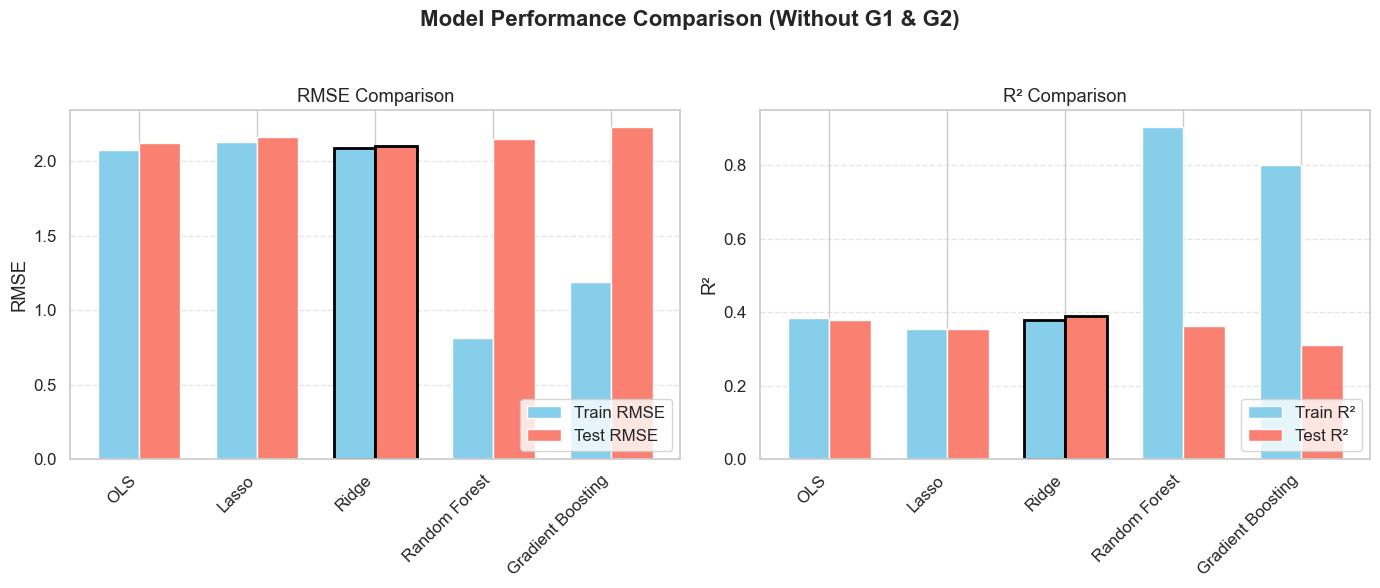

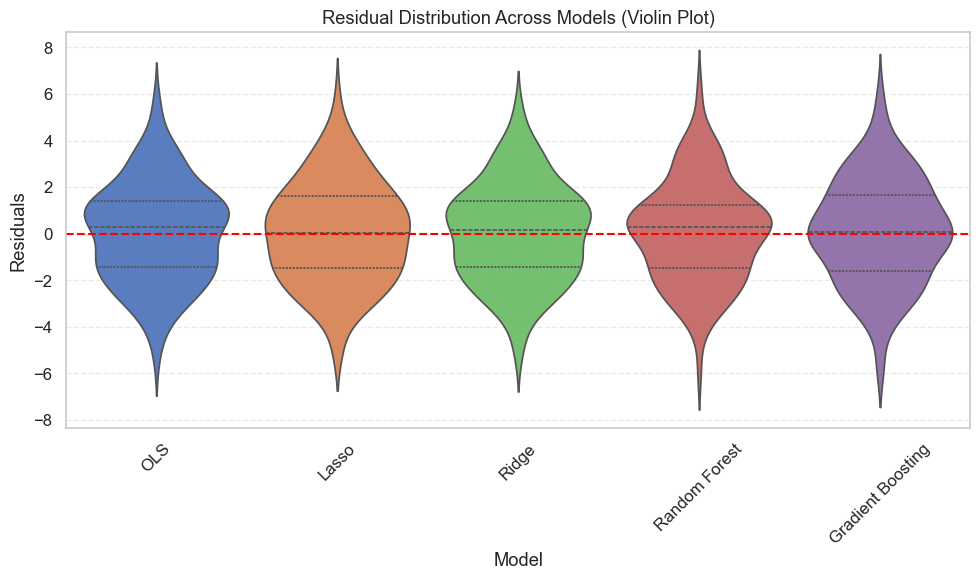

In [275]:
# ------------------- Data (remove G1 and G2) -------------------
X = df_encoded.drop(columns=['G3', 'G1', 'G2'])
y = df_no_outliers['G3']  # keep outlier removal
X = X.loc[y.index]

# Train/test split with random seed for reproducibility
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize results container 
results = []

# ------------------- 1. Scaled OLS -------------------

# Scale features
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled  = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

# Add constant for intercept
X_train_scaled = sm.add_constant(X_train_scaled)
X_test_scaled  = sm.add_constant(X_test_scaled)

# Fit OLS on scaled features
ols_model = sm.OLS(y_train, X_train_scaled).fit(cov_type='HC3') # robust SEs

# Predictions
y_pred_train_ols = ols_model.predict(X_train_scaled)
y_pred_test_ols  = ols_model.predict(X_test_scaled)

results.append({
    "Model": "OLS",
    "Train_RMSE": mean_squared_error(y_train, y_pred_train_ols) ** 0.5,
    "Test_RMSE": mean_squared_error(y_test, y_pred_test_ols) ** 0.5,
    "Train_R2": r2_score(y_train, y_pred_train_ols),
    "Test_R2": r2_score(y_test, y_pred_test_ols)
})

# ------------------- 2. Lasso -------------------
lasso_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', Lasso(random_state=42))
])

param_grid = {'lasso__alpha': [0.001, 0.01, 0.1, 1, 10]}
grid_lasso = GridSearchCV(lasso_pipe, param_grid, cv=5, scoring='r2')
grid_lasso.fit(X_train, y_train)
best_lasso = grid_lasso.best_estimator_

y_pred_train_lasso = best_lasso.predict(X_train)
y_pred_test_lasso  = best_lasso.predict(X_test)

results.append({
    "Model": "Lasso",
    "Train_RMSE": mean_squared_error(y_train, y_pred_train_lasso) ** 0.5,
    "Test_RMSE": mean_squared_error(y_test, y_pred_test_lasso) ** 0.5,
    "Train_R2": r2_score(y_train, y_pred_train_lasso),
    "Test_R2": r2_score(y_test, y_pred_test_lasso)
})

# ------------------- 3. Ridge -------------------
ridge_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge(random_state=42))
])

param_grid = {'ridge__alpha': [0.01, 0.1, 1, 10, 100]}
grid_ridge = GridSearchCV(ridge_pipe, param_grid, cv=5, scoring='r2')
grid_ridge.fit(X_train, y_train)
best_ridge = grid_ridge.best_estimator_

y_pred_train_ridge = best_ridge.predict(X_train)
y_pred_test_ridge  = best_ridge.predict(X_test)

results.append({
    "Model": "Ridge",
    "Train_RMSE": mean_squared_error(y_train, y_pred_train_ridge) ** 0.5,
    "Test_RMSE": mean_squared_error(y_test, y_pred_test_ridge) ** 0.5,
    "Train_R2": r2_score(y_train, y_pred_train_ridge),
    "Test_R2": r2_score(y_test, y_pred_test_ridge)
})

# ------------------- 4. Random Forest -------------------
rf = RandomForestRegressor(random_state=42, n_estimators=200)
rf.fit(X_train, y_train)

y_pred_train_rf = rf.predict(X_train)
y_pred_test_rf  = rf.predict(X_test)

results.append({
    "Model": "Random Forest",
    "Train_RMSE": mean_squared_error(y_train, y_pred_train_rf) ** 0.5,
    "Test_RMSE": mean_squared_error(y_test, y_pred_test_rf) ** 0.5,
    "Train_R2": r2_score(y_train, y_pred_train_rf),
    "Test_R2": r2_score(y_test, y_pred_test_rf)
})

# ------------------- 5. Gradient Boosting -------------------
gb = GradientBoostingRegressor(random_state=42, n_estimators=200)
gb.fit(X_train, y_train)

y_pred_train_gb = gb.predict(X_train)
y_pred_test_gb  = gb.predict(X_test)

results.append({
    "Model": "Gradient Boosting",
    "Train_RMSE": mean_squared_error(y_train, y_pred_train_gb) ** 0.5,
    "Test_RMSE": mean_squared_error(y_test, y_pred_test_gb) ** 0.5,
    "Train_R2": r2_score(y_train, y_pred_train_gb),
    "Test_R2": r2_score(y_test, y_pred_test_gb)
})

# ------------------- Convert results to DataFrame -------------------
results_df = pd.DataFrame(results)
display(results_df)

# ------------------- Plot comparisons -------------------
best_idx = results_df['Test_RMSE'].idxmin()
x = np.arange(len(results_df['Model']))
width = 0.35

fig, axes = plt.subplots(1, 2, figsize=(14,6))
train_color = 'skyblue'
test_color = 'salmon'
highlight_edge = 'black'

# RMSE
for i in range(len(x)):
    edge = highlight_edge if i == best_idx else None
    axes[0].bar(x[i] - width/2, results_df['Train_RMSE'][i], width=width, color=train_color,
                edgecolor=edge, linewidth=2 if edge else 1, label='Train RMSE' if i==0 else "")
    axes[0].bar(x[i] + width/2, results_df['Test_RMSE'][i], width=width, color=test_color,
                edgecolor=edge, linewidth=2 if edge else 1, label='Test RMSE' if i==0 else "")

axes[0].set_xticks(x)
axes[0].set_xticklabels(results_df['Model'], rotation=45, ha='right')
axes[0].set_title("RMSE Comparison")
axes[0].set_ylabel("RMSE")
axes[0].grid(axis='y', linestyle='--', alpha=0.5)
axes[0].legend(loc='lower right')

# R²
for i in range(len(x)):
    edge = highlight_edge if i == best_idx else None
    axes[1].bar(x[i] - width/2, results_df['Train_R2'][i], width=width, color=train_color,
                edgecolor=edge, linewidth=2 if edge else 1, label='Train R²' if i==0 else "")
    axes[1].bar(x[i] + width/2, results_df['Test_R2'][i], width=width, color=test_color,
                edgecolor=edge, linewidth=2 if edge else 1, label='Test R²' if i==0 else "")

axes[1].set_xticks(x)
axes[1].set_xticklabels(results_df['Model'], rotation=45, ha='right')
axes[1].set_title("R² Comparison")
axes[1].set_ylabel("R²")
axes[1].grid(axis='y', linestyle='--', alpha=0.5)
axes[1].legend(loc='lower right')

plt.suptitle("Model Performance Comparison (Without G1 & G2)", fontsize=16, weight='bold')
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()

# ---------------- Violin Plot ----------------
residuals_dict = {
    "OLS": y_test - y_pred_test_ols,
    "Lasso": y_test - y_pred_test_lasso,
    "Ridge": y_test - y_pred_test_ridge,
    "Random Forest": y_test - y_pred_test_rf,
    "Gradient Boosting": y_test - y_pred_test_gb
}

# Convert to long-form DataFrame for seaborn
residuals_df = pd.DataFrame(residuals_dict)
residuals_long = residuals_df.melt(var_name="Model", value_name="Residuals")

plt.figure(figsize=(10,6))
sns.violinplot(
    x="Model",
    y="Residuals",
    data=residuals_long,
    hue="Model",       # assign x to hue
    palette="muted",   # now allowed
    inner="quartile",
    legend=False       # hide extra legend
)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residual Distribution Across Models (Violin Plot)")
plt.ylabel("Residuals")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

### Interpreting Best Model `without` 'G1' and 'G2' as predictors

Best model selected based on Test RMSE: Ridge


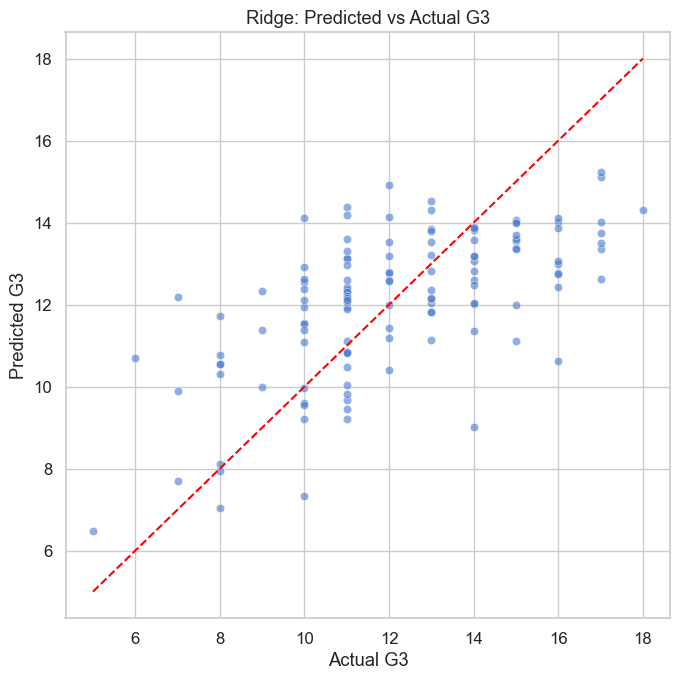

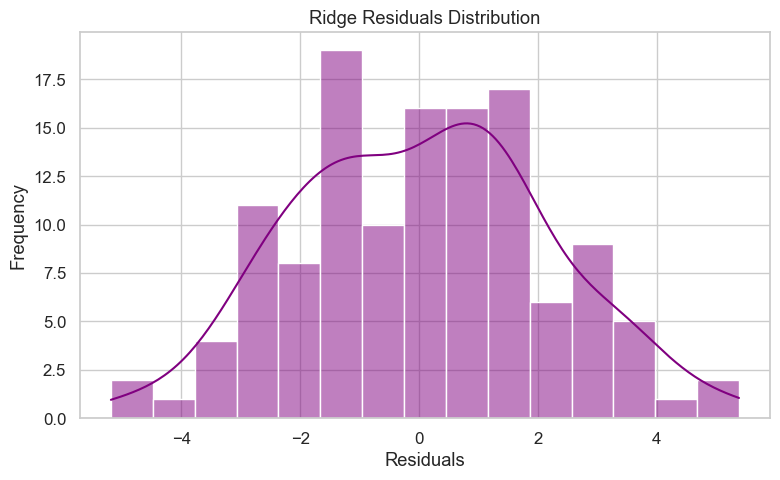

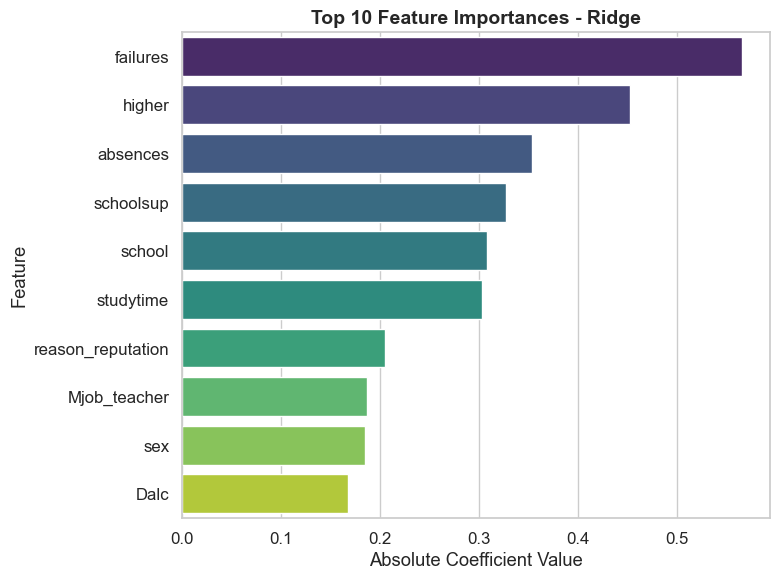

Top 10 important features:


failures             0.565870
higher               0.452681
absences             0.353691
schoolsup            0.326584
school               0.307403
studytime            0.302993
reason_reputation    0.204352
Mjob_teacher         0.186747
sex                  0.184888
Dalc                 0.167625
dtype: float64

In [276]:
# ------------------ Ridge Model Interpretation ------------------

# Identify the best model index
best_idx = results_df['Test_RMSE'].idxmin()
best_model_name = results_df.loc[best_idx, 'Model']
print(f"Best model selected based on Test RMSE: {best_model_name}")

# ------------------ Predictions vs Actuals ------------------
# Use Ridge predictions
y_pred_ridge = best_ridge.predict(X_test)

plt.figure(figsize=(7,7))
sns.scatterplot(x=y_test, y=y_pred_ridge, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel("Actual G3")
plt.ylabel("Predicted G3")
plt.title("Ridge: Predicted vs Actual G3")
plt.tight_layout()
plt.show()

# ------------------ Residuals ------------------
residuals_ridge = y_test - y_pred_ridge

plt.figure(figsize=(8,5))
sns.histplot(residuals_ridge, kde=True, color='purple', bins=15)
plt.title("Ridge Residuals Distribution")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# ------------------ Top 10 Feature Importances (Ridge) ------------------
if best_model_name == "Ridge":
    ridge_coefs = best_ridge.named_steps['ridge'].coef_
    feat_importance = pd.Series(ridge_coefs, index=X.columns).abs().sort_values(ascending=False)

    top_10_features = feat_importance.head(10)

    plt.figure(figsize=(8,6))
    sns.barplot(
    x=top_10_features.values, 
    y=top_10_features.index, 
    hue=top_10_features.index,  
    palette="viridis",
    legend=False                 
    )
    plt.title("Top 10 Feature Importances - Ridge", fontsize=14, weight='bold')
    plt.xlabel("Absolute Coefficient Value")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

    print("Top 10 important features:")
    display(top_10_features)
